##Biblioteke

In [ ]:

import random
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torchvision import models,datasets,transforms
from torch.nn.functional import relu
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset,DataLoader
from torchvision.transforms import ToTensor,Resize,Compose,ToPILImage
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import torch.nn.functional as F
import random
from torch.cuda.amp import GradScaler, autocast
import matplotlib.pyplot as plt
import zipfile
import os
import copy
import time
import warnings
warnings.filterwarnings("ignore")

In [ ]:
pip install kaggle

In [ ]:
os.environ["KAGGLE_USERNAME"]="milicaaleksic"
os.environ["KAGGLE_KEY"]="6ac87aecce60e57a63e73a6710612e08"

In [ ]:
!kaggle datasets download -d sadhliroomyprime/cricket-semantic-segmentation

Dataset URL: https://www.kaggle.com/datasets/sadhliroomyprime/cricket-semantic-segmentation
License(s): Attribution 4.0 International (CC BY 4.0)
 97% 500M/514M [00:06<00:00, 61.4MB/s]
100% 514M/514M [00:06<00:00, 85.7MB/s]


In [ ]:
zip_file = '/content/cricket-semantic-segmentation.zip'
extract_folder = '/content/cricket-semantic-segmentation/'

with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)


extracted_files = os.listdir(extract_folder)
print("Extracted files:", extracted_files)

Extracted files: ['www.acmeai.tech ODataset 4 - Cricket Semantic Segmentation.pdf', 'www.acmeai.tech ODataset 4 - Cricket Semantic Segmentation']


In [ ]:
image_folder = '/content/cricket-semantic-segmentation/www.acmeai.tech ODataset 4 - Cricket Semantic Segmentation/images/'
images_path = []
for filename in os.listdir(image_folder):
    if filename.endswith(".png") and not filename.endswith("fuse.png") and not filename.endswith("save.png"):
      img_path = os.path.join(image_folder,filename)
      images_path.append(img_path)


In [ ]:
json_doc = '/content/cricket-semantic-segmentation/www.acmeai.tech ODataset 4 - Cricket Semantic Segmentation/classes/classes.json'
import json
f = open(json_doc)
data = json.load(f)

In [ ]:
data

[{'id': 1323900,
  'project_id': 96398,
  'name': 'Background',
  'color': '#916041',
  'type': 'object',
  'createdAt': '2022-08-24T06:27:48.000Z',
  'updatedAt': '2022-08-24T06:27:48.000Z',
  'attribute_groups': []},
 {'id': 1323899,
  'project_id': 96398,
  'name': 'Ground',
  'color': '#e2d5de',
  'type': 'object',
  'createdAt': '2022-08-24T06:27:36.000Z',
  'updatedAt': '2022-08-24T06:27:36.000Z',
  'attribute_groups': []},
 {'id': 1323898,
  'project_id': 96398,
  'name': 'Bowler',
  'color': '#0018fd',
  'type': 'object',
  'createdAt': '2022-08-24T06:26:50.000Z',
  'updatedAt': '2022-08-24T06:26:50.000Z',
  'attribute_groups': []},
 {'id': 1323897,
  'project_id': 96398,
  'name': 'Batsmen',
  'color': '#b07a53',
  'type': 'object',
  'createdAt': '2022-08-24T06:26:44.000Z',
  'updatedAt': '2022-08-24T06:26:44.000Z',
  'attribute_groups': []},
 {'id': 1323896,
  'project_id': 96398,
  'name': 'Wicket Keeper',
  'color': '#8fdfa9',
  'type': 'object',
  'createdAt': '2022-08-24

In [ ]:
lookup_classes = {}
for ind,d in enumerate(data):
  hex_code = d['color']
  hex_code = hex_code.lstrip('#')
  rgb = tuple(int(hex_code[i:i+2], 16) for i in (0, 2 ,4))
  lookup_classes[ind] = rgb

In [ ]:
lookup_classes

{0: (145, 96, 65),
 1: (226, 213, 222),
 2: (0, 24, 253),
 3: (176, 122, 83),
 4: (143, 223, 169),
 5: (226, 9, 89),
 6: (194, 254, 107),
 7: (94, 141, 56),
 8: (30, 71, 42)}

In [ ]:
def transform_mask(mask,n_class):


  m,n = mask.shape[0],mask.shape[1]
  result = np.zeros((m,n,n_class))


  for i in range(n_class):
    indexes = np.where((mask[:,:,0]==lookup_classes[i][0]) & (mask[:,:,1]==lookup_classes[i][1])&( mask[:,:,2]==lookup_classes[i][2]))
    result[indexes[0],indexes[1],i] = 1

  return result

In [ ]:
masks_path=[]

##Podela dataset

In [ ]:
train_val_images_path,test_images_path= train_test_split(
    images_path,test_size=0.2,random_state=42,shuffle=True
)

In [ ]:
train_images_path, val_images_path = train_test_split(
    train_val_images_path, test_size=0.25, random_state=42,shuffle=True
)

##Klasa


In [ ]:
def calculate_mean_std(image_paths):
    mean = np.zeros(3)
    std = np.zeros(3)
    num_images = len(image_paths) * 2

    for image_path in image_paths:
        image = np.asarray(Image.open(image_path).convert('RGB')) / 255.0


        mean += image.mean(axis=(0, 1))
        std += image.std(axis=(0, 1))


        flipped_image = np.fliplr(image)


        mean += flipped_image.mean(axis=(0, 1))
        std += flipped_image.std(axis=(0, 1))

    mean /= num_images
    std /= num_images

    return mean, std



mean, std = calculate_mean_std(images_path)

print(f'Mean: {mean}')
print(f'Std: {std}')

Mean: [0.44364604 0.4796989  0.35485599]
Std: [0.14016555 0.1412527  0.13715699]


In [ ]:
from torchvision.transforms import v2
hflipper = v2.RandomHorizontalFlip(p=1)

In [ ]:
class CustomDataset(Dataset):
  def __init__ (self,images_path,n_class,transform=None):
    self.images_path = images_path
    self.transform = transform

    self.images=[]
    self.masks = []
    desired_height,desired_width = 512,512

    for image_path in images_path:
      mask_path = image_path + "___fuse.png"
      image = np.asarray(Image.open(image_path).convert('RGBA'))
      mask = np.asarray(Image.open(mask_path))

      mask = transform_mask(mask,n_class)
      image = cv2.resize(image,(desired_height,desired_width),interpolation = cv2.INTER_LINEAR)
      mask = cv2.resize(mask,(desired_height,desired_width),interpolation = cv2.INTER_NEAREST)

      image_flip = image.copy()
      mask_flip = mask.copy()
      image_flip = np.fliplr(image_flip)
      mask_flip = np.fliplr(mask_flip)

      image = np.transpose(image,(2,0,1))/255.0
      mask = np.transpose(mask,(2,0,1))

      image_flip = np.transpose(image_flip,(2,0,1))/255.0
      mask_flip = np.transpose(mask_flip,(2,0,1))



      image_tensor = torch.from_numpy(image.astype(np.float32))
      mask_tensor = torch.from_numpy(mask.astype(np.float32))

      image_flip_tensor = torch.from_numpy(image_flip.astype(np.float32))
      mask_flip_tensor = torch.from_numpy(mask_flip.astype(np.float32))

      self.images.append(image_tensor)
      self.masks.append(mask_tensor)

      self.images.append(image_flip_tensor)
      self.masks.append(mask_flip_tensor)



  def __len__(self):
        return len(self.images)

  def __getitem__(self,index):
      image = self.images[index]
      mask = self.masks[index]
      if self.transform:
        image = self.transform(image)

      return (image,mask)

##UNet
|

In [ ]:
class Conv_block(nn.Module):
  def __init__(self,in_c,out_c):
    super().__init__()
    self.conv1 = nn.Conv2d(in_c,out_c,kernel_size=3,padding=1)
    self.bn1 = nn.BatchNorm2d(out_c)

    self.conv2 = nn.Conv2d(out_c,out_c,kernel_size=3,padding=1)
    self.bn2 = nn.BatchNorm2d(out_c)

    self.relu = nn.ReLU()

  def forward(self,inputs):
      x = self.conv1(inputs)
      x = self.bn1(x)
      x = self.relu(x)

      x = self.conv2(x)
      x = self.bn2(x)
      x = self.relu(x)

      return x

class Encoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv = Conv_block(in_c, out_c)
        self.pool = nn.MaxPool2d((2, 2))

    def forward(self, inputs):
        x = self.conv(inputs)
        p = self.pool(x)

        return x, p

class Decoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
        self.conv = Conv_block(out_c+out_c, out_c)

    def forward(self, inputs, skip):
        x = self.up(inputs)
        x = torch.cat([x, skip], axis=1)
        x = self.conv(x)

        return x

class Unet(nn.Module):
    def __init__(self,n_class):
        super().__init__()


        self.e1 = Encoder_block(3, 64)
        self.e2 = Encoder_block(64, 128)
        self.e3 = Encoder_block(128, 256)
        self.e4 = Encoder_block(256, 512)


        self.b = Conv_block(512, 1024)


        self.d1 = Decoder_block(1024, 512)
        self.d2 = Decoder_block(512, 256)
        self.d3 = Decoder_block(256, 128)
        self.d4 = Decoder_block(128, 64)


        self.outputs = nn.Conv2d(64, n_class, kernel_size=1, padding=0)

    def forward(self, inputs):

        s1, p1 = self.e1(inputs)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)


        b = self.b(p4)


        d1 = self.d1(b, s4)
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2, s2)
        d4 = self.d4(d3, s1)


        outputs = self.outputs(d4)

        return outputs

##SegNet

In [ ]:
class Conv_block_segnet(nn.Module):
  def __init__(self,in_c,out_c):
    super().__init__()

    self.conv = nn.Conv2d(in_c,out_c,kernel_size=3,padding=1)

    self.bn = nn.BatchNorm2d(out_c)
    self.relu = nn.ReLU()

  def forward(self,inputs):
      x = self.conv(inputs)
      x = self.bn(x)
      x = self.relu(x)

      return x

class Encoder_block_segnet(nn.Module):
    def __init__(self, in_c, out_c,depth = 2):

        super().__init__()
        self.layers = nn.ModuleList()

        for i in range(depth):
          self.layers.append(Conv_block_segnet(in_c if i==0 else out_c,out_c))


        self.pool = nn.MaxPool2d(kernel_size=2,stride=2,return_indices=True)

    def forward(self, inputs):
        x = inputs
        for layer in self.layers:
          x = layer(x)

        x,ind = self.pool(x)
        return  (x,ind)


class Decoder_block_segnet(nn.Module):
    def __init__(self, in_c, out_c,depth=2,classification=False):
        super().__init__()
        self.unpool = nn.MaxUnpool2d(kernel_size=2,stride=2)

        self.layers = nn.ModuleList()

        for i in range(depth):
          if i==depth-1 and classification:
            self.layers.append(nn.Conv2d(in_c,out_c,kernel_size = 3,padding=1))
          elif i==depth-1:
            self.layers.append(Conv_block_segnet(in_c,out_c))
          else:
            self.layers.append(Conv_block_segnet(in_c,in_c))


    def forward(self, inputs,ind):
        x = self.unpool(inputs,ind)
        for layer in self.layers:
          x = layer(x)

        return x

class SegNet(nn.Module):
  def __init__(self,n_class):
    super().__init__()

    self.enc0 = Encoder_block_segnet(3,64)
    self.enc1 = Encoder_block_segnet(64,128)
    self.enc2 = Encoder_block_segnet(128,256,depth = 3)
    self.enc3 = Encoder_block_segnet(256,512,depth = 3)

    self.b1 = Encoder_block_segnet(512,512,depth = 3)
    self.b2 = Decoder_block_segnet(512,512,depth = 3)

    self.dec0 = Decoder_block_segnet(512,256,depth=3)
    self.dec1 = Decoder_block_segnet(256,128,depth=3)
    self.dec2 = Decoder_block_segnet(128,64)
    self.dec3 = Decoder_block_segnet(64,n_class,classification=True)

  def forward(self,x):


    e_0,ind_0 = self.enc0(x)

    e_1,ind_1 = self.enc1(e_0)

    e_2,ind_2 = self.enc2(e_1)

    e_3,ind_3 = self.enc3(e_2)

    b_0,ind_b = self.b1(e_3)
    b_1 = self.b2(b_0,ind_b)

    d_0 = self.dec0(b_1,ind_3)
    d_1 = self.dec1(d_0,ind_2)
    d_2 = self.dec2(d_1,ind_1)

    output = self.dec3(d_2,ind_0)
    return output


##DeepLabv3+

In [ ]:
class Atrous_Convolution(nn.Module):
    def __init__(self, in_c, kernel_size, padding, dilation_rate, out_c=256):
        super().__init__()
        self.conv = nn.Conv2d(in_channels=in_c, out_channels=out_c, kernel_size=kernel_size, padding=padding, dilation=dilation_rate, bias=False)
        self.bn = nn.BatchNorm2d(out_c)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

class ASPP(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv_1x1 = Atrous_Convolution(in_c=in_c, out_c=out_c, kernel_size=1, padding=0, dilation_rate=1)
        self.conv_6x6 = Atrous_Convolution(in_c=in_c, out_c=out_c, kernel_size=3, padding=6, dilation_rate=6)
        self.conv_12x12 = Atrous_Convolution(in_c=in_c, out_c=out_c, kernel_size=3, padding=12, dilation_rate=12)
        self.conv_18x18 = Atrous_Convolution(in_c=in_c, out_c=out_c, kernel_size=3, padding=18, dilation_rate=18)

        self.image_pool = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channels=in_c, out_channels=out_c, kernel_size=1, stride=1, padding=0, dilation=1, bias=False),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True)
        )
        self.final_conv = Atrous_Convolution(in_c=out_c*5, out_c=out_c, kernel_size=1, padding=0, dilation_rate=1)

    def forward(self, x):
        x_1x1 = self.conv_1x1(x)
        x_6x6 = self.conv_6x6(x)
        x_12x12 = self.conv_12x12(x)
        x_18x18 = self.conv_18x18(x)
        img_pool_opt = self.image_pool(x)
        img_pool_opt = F.interpolate(img_pool_opt, size=x_18x18.size()[2:], mode='bilinear', align_corners=True)
        concat = torch.cat((x_1x1, x_6x6, x_12x12, x_18x18, img_pool_opt), dim=1)
        x_final_conv = self.final_conv(concat)
        return x_final_conv

class ResNet_50(nn.Module):
    def __init__(self, output_layer=None):
        super().__init__()
        self.pretrained = models.resnet50(pretrained=True)
        self.output_layer = output_layer
        self.layers = list(self.pretrained._modules.keys())
        self.layer_count = 0
        for l in self.layers:
            if l != self.output_layer:
                self.layer_count += 1
            else:
                break
        for i in range(1, len(self.layers)-self.layer_count):
            self.dummy_var = self.pretrained._modules.pop(self.layers[-i])
        self.net = nn.Sequential(self.pretrained._modules)
        self.pretrained = None

    def forward(self, x):
        x = self.net(x)
        return x

class Deeplabv3Plus(nn.Module):
    def __init__(self, n_class):
        super().__init__()
        self.backbone = ResNet_50(output_layer='layer3')
        self.low_level_features = ResNet_50(output_layer='layer1')
        self.assp = ASPP(in_c=1024, out_c=256)
        self.conv1x1 = Atrous_Convolution(in_c=256, out_c=48, kernel_size=1, dilation_rate=1, padding=0)
        self.conv3x3 = nn.Sequential(
            nn.Conv2d(304, 256, 3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.classifier = nn.Conv2d(256, n_class, 1)

    def forward(self, x):
        x_backbone = self.backbone(x)
        x_low_level = self.low_level_features(x)
        x_assp = self.assp(x_backbone)
        x_upsampled = F.interpolate(x_assp, scale_factor=4, mode='bilinear', align_corners=True)
        x_conv1x1 = self.conv1x1(x_low_level)
        x_cat = torch.cat([x_conv1x1, x_upsampled], dim=1)
        x_3x3 = self.conv3x3(x_cat)
        x_3x3_upscaled = F.interpolate(x_3x3, scale_factor=4, mode='bilinear', align_corners=True)
        x_out = self.classifier(x_3x3_upscaled)
        return x_out


##Funckije za treniranje

In [ ]:
def calculate_metrics(pred_mask, true_mask, num_classes):

    if pred_mask.shape == true_mask.shape:

        device = pred_mask.device


        metrics = {
            "accuracy": [],
            "precision": [],
            "recall": [],
            "f1_score": [],
            "iou": []
        }

        for cls in range(num_classes):
            pred_cls = (pred_mask == cls)
            true_cls = (true_mask == cls)

            tp = torch.sum(pred_cls & true_cls)
            fp = torch.sum(pred_cls & ~true_cls)
            fn = torch.sum(~pred_cls & true_cls)
            tn = torch.sum(~pred_cls & ~true_cls)

            accuracy = (tp + tn).float() / (tp + fn + tn + fp).float() if (tp + fn + tn + fp) > 0 else 0
            precision = tp / (tp + fp) if tp + fp > 0 else 0
            recall = tp / (tp + fn) if tp + fn > 0 else 0
            f1 = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0
            intersection = tp
            union = tp + fp + fn
            iou = intersection.float() / union if union > 0 else 0
            dice = 2 * intersection.float() / (2 * intersection + fp + fn) if (2 * intersection + fp + fn) > 0 else 0

            metrics["accuracy"].append(accuracy)
            metrics["precision"].append(precision)
            metrics["recall"].append(recall)
            metrics["f1_score"].append(f1)
            metrics["iou"].append(iou)


        avg_metrics = {k: sum(v) / len(v) for k, v in metrics.items()}

        return avg_metrics

    return {"accuracy": 0, "iou": 0, "precision": 0,"recall":0,"f1_score":0}

In [ ]:
def train_with_center(model,train_images_path,val_images_path,device,path,num_epochs,learning_rate,n_class,patience = 5):


    batch_size = 4

    transformations = transforms.Compose([transforms.Lambda(lambda x:x[:3]), transforms.Normalize(mean=mean, std=std)])
    train_dataset = CustomDataset(train_images_path,n_class,transform =transformations)
    train_dataloader = DataLoader(train_dataset,batch_size=4,shuffle=True)

    val_dataset = CustomDataset(val_images_path,n_class,transform = transformations )
    val_dataloader = DataLoader(val_dataset,batch_size=4,shuffle=True)

    learning_rate = learning_rate
    epochs = num_epochs
    loss_fn  = nn.CrossEntropyLoss()

    best_val_iou = 0
    best_model_weights = None
    patience_counter = 0
    best_epoch = 0
    train_losses = []
    train_mIoU = []
    val_mIoU = []
    optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate )
    torch.cuda.empty_cache()
    for e in range(epochs):
        print(f"Epoch {e+1}\n-------------------------------\n")
        train_loss = 0
        model.train()
        train_acc = 0
        train_iou = 0
        train_precision = 0
        train_recall = 0
        train_f1=0
        for i,data in enumerate(train_dataloader):

            data_x,data_y = data
            data_x,data_y = data_x.to(device),data_y.to(device)

            optimizer.zero_grad()
            y = model(data_x)

            loss = loss_fn(y,data_y)
            loss.backward()

            optimizer.step()
            train_loss+=loss.item()



            y_softmax = F.softmax(y, dim=1)



            _, predicted_classes = torch.max(y_softmax, dim=1)
            _, ground_truth_classes = torch.max(data_y,dim = 1)


            metrics = calculate_metrics(predicted_classes,ground_truth_classes, n_class)
            train_acc += metrics["accuracy"]
            train_iou += metrics["iou"]

        train_loss /= len(train_dataloader)
        train_acc /= len(train_dataloader)
        train_iou /= len(train_dataloader)
        train_mIoU.append(train_iou.item())
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0
        val_acc = 0
        val_iou = 0
        val_precision = 0
        val_recall = 0
        val_f1=0
        with torch.no_grad():
            for data in val_dataloader:
                data_x, data_y = data
                data_x, data_y = data_x.to(device), data_y.to(device)
                y = model(data_x)

                loss = loss_fn(y, data_y)
                val_loss += loss.item()

                y_softmax = F.softmax(y, dim=1)

                _, predicted_classes = torch.max(y_softmax, dim=1)
                _, ground_truth_classes = torch.max(data_y, dim=1)


                metrics =calculate_metrics(predicted_classes,ground_truth_classes, n_class)
                val_acc += metrics["accuracy"]
                val_iou += metrics["iou"]

        val_loss /= len(val_dataloader)
        val_acc /= len(val_dataloader)
        val_iou /= len(val_dataloader)
        val_mIoU.append(val_iou.item())


        print(f" Train Loss: {train_loss}, Val Loss: {val_loss}, Train Acc: {train_acc},Val Acc: {val_acc},\n Train IoU: {train_iou},Val IoU: {val_iou}")


        if best_val_iou < val_iou:
            best_val_iou = val_iou
            best_model_weights = copy.deepcopy(model.state_dict())
            best_epoch = e+1
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print("Aktiviran early stopping .")
            break
    print(f"Gotov trening. Najbolji validation mIoU: {best_val_iou} u epohi: {best_epoch}")
    if e!=4:
      fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))
      ax1.plot(range(e+1), train_losses, label='train loss', color='blue')
      ax1.set_title('Train loss')
      ax1.set_xlabel('Epoch')
      ax1.set_ylabel('loss')
      ax1.legend()


      ax2.plot(range(e+1), train_mIoU, label='train mIoU', color='blue')
      ax2.plot(range(e+1), val_mIoU, label='val mIoU', color='orange')
      ax2.set_title('Train/val mIoU')
      ax2.set_xlabel('Epoch')
      ax2.set_ylabel('mIoU')
      ax2.legend()


      plt.tight_layout()
      plt.show()

    torch.save(best_model_weights,path)

In [ ]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

def train_with_lr_decay(model, train_images_path, val_images_path, device, path, num_epochs, learning_rate, n_class, patience=5):
    batch_size = 4

    transformations = transforms.Compose([transforms.Lambda(lambda x:x[:3]), transforms.Normalize(mean=mean, std=std)])
    train_dataset = CustomDataset(train_images_path, n_class, transform=transformations)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    val_dataset = CustomDataset(val_images_path, n_class, transform=transformations)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

    epochs = num_epochs
    loss_fn = nn.CrossEntropyLoss()

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

    best_val_iou = 0
    best_model_weights = copy.deepcopy(model.state_dict())
    patience_counter = 0
    best_epoch = 0
    train_losses = []
    train_mIoU = []
    val_mIoU = []

    for e in range(epochs):
        print(f"Epoch {e + 1}\n-------------------------------\n")
        train_loss = 0
        model.train()
        train_acc = 0
        train_iou = 0

        for i, data in enumerate(train_dataloader):
            data_x, data_y = data
            data_x, data_y = data_x.to(device), data_y.to(device)

            optimizer.zero_grad()
            y = model(data_x)

            loss = loss_fn(y, data_y)
            loss.backward()

            optimizer.step()
            train_loss += loss.item()

            y_softmax = F.softmax(y, dim=1)
            _, predicted_classes = torch.max(y_softmax, dim=1)
            _, ground_truth_classes = torch.max(data_y, dim=1)

            metrics = calculate_metrics(predicted_classes, ground_truth_classes, n_class)
            train_acc += metrics["accuracy"]
            train_iou += metrics["iou"]

        train_loss /= len(train_dataloader)
        train_acc /= len(train_dataloader)
        train_iou /= len(train_dataloader)
        train_mIoU.append(train_iou.item())
        train_losses.append(train_loss)



        model.eval()
        val_loss = 0
        val_acc = 0
        val_iou = 0

        with torch.no_grad():
            for data in val_dataloader:
                data_x, data_y = data
                data_x, data_y = data_x.to(device), data_y.to(device)
                y = model(data_x)

                loss = loss_fn(y, data_y)
                val_loss += loss.item()

                y_softmax = F.softmax(y, dim=1)
                _, predicted_classes = torch.max(y_softmax, dim=1)
                _, ground_truth_classes = torch.max(data_y, dim=1)

                metrics = calculate_metrics(predicted_classes, ground_truth_classes, n_class)
                val_acc += metrics["accuracy"]
                val_iou += metrics["iou"]

        val_loss /= len(val_dataloader)
        val_acc /= len(val_dataloader)
        val_iou /= len(val_dataloader)
        val_mIoU.append(val_iou.item())

        print(f" Train Loss: {train_loss}, Val Loss: {val_loss}, Train Acc: {train_acc},Val Acc: {val_acc},\n Train IoU: {train_iou},Val IoU: {val_iou}")

        scheduler.step(val_iou)

        if val_iou > best_val_iou:
            best_val_iou = val_iou
            best_model_weights = copy.deepcopy(model.state_dict())
            best_epoch = e + 1
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print("Aktiviran early stopping .")
            break

    print(f"Gotov trening. Najbolji validation mIoU: {best_val_iou} u epohi: {best_epoch}")


    torch.save(best_model_weights, path)


    if e != 4:
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))
        ax1.plot(range(e + 1), train_losses, label='train loss', color='blue')
        ax1.set_title('Train loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()

        ax2.plot(range(e + 1), train_mIoU, label='train mIoU', color='blue')
        ax2.plot(range(e + 1), val_mIoU, label='val mIoU', color='orange')
        ax2.set_title('Train/val mIoU')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('mIoU')
        ax2.legend()

        plt.tight_layout()
        plt.show()

## Funkcije za testiranje

In [ ]:
from matplotlib.colors import ListedColormap
colors = [item['color'] for item in data]
cmap = ListedColormap(colors)



In [ ]:
def denormalize(image, mean, std):
    mean = np.array(mean).reshape(3, 1, 1)
    std = np.array(std).reshape(3, 1, 1)
    denormalized_image = image * std + mean
    return denormalized_image

In [ ]:
def tn_2_np_center(tensor):
    if isinstance(tensor, torch.Tensor):
        img_np = tensor.cpu().detach().numpy()
    else:
        img_np = np.array(tensor)

    if img_np.shape[0] == 3:
      denormalized_image = denormalize(img_np, mean, std)

      denormalized_image= np.transpose(denormalized_image, (1, 2, 0))
      denormalized_image = np.clip(denormalized_image, 0, 255)
      img_np = denormalized_image
    return img_np

def test_center(model, test_images_path, device, n_class):

    batch_size = 4

    transformations = transforms.Compose([transforms.Lambda(lambda x:x[:3]), transforms.Normalize(mean=mean, std=std)])

    test_dataset = CustomDataset(test_images_path, n_class, transform=transformations )
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    loss_fn = nn.CrossEntropyLoss()
    model.eval()
    test_loss = 0
    test_acc = 0
    test_iou = 0
    test_precision = 0
    test_recall = 0
    test_f1 = 0
    predictions = []
    with torch.no_grad():
        for data in test_dataloader:
            data_x, data_y = data
            data_x, data_y = data_x.to(device), data_y.to(device)

            y = model(data_x)

            loss = loss_fn(y, data_y)
            test_loss += loss.item()

            y_softmax = F.softmax(y, dim=1)
            _, predicted_classes = torch.max(y_softmax, dim=1)
            _, ground_truth_classes = torch.max(data_y, dim=1)

            metrics = calculate_metrics(predicted_classes, ground_truth_classes, n_class)
            test_acc += metrics["accuracy"]
            test_iou += metrics["iou"]
            test_precision += metrics["precision"]
            test_recall += metrics["recall"]
            test_f1 += metrics["f1_score"]

            for batch_ind in range(batch_size):
              predictions.append((data_x[batch_ind,:,:,:], predicted_classes[batch_ind,:,:], ground_truth_classes[batch_ind,:,:]))


    test_loss /= len(test_dataloader)
    test_acc /= len(test_dataloader)
    test_iou /= len(test_dataloader)
    test_precision /= len(test_dataloader)
    test_recall /= len(test_dataloader)
    test_f1 /= len(test_dataloader)

    print(f" Test Loss: {test_loss}, Test Acc: {test_acc}, Test IoU: {test_iou}")
    print(f" Test Precision: {test_precision}, Test Recall: {test_recall}, Test f1: {test_f1}")

    visualize_results_center(predictions)

def visualize_results_center(predictions):

    num_images_to_visualize = min(len(predictions), 10)

    cols = 3
    rows = num_images_to_visualize
    plt.figure(figsize=(30, 25))

    for i in range(num_images_to_visualize):
        data_x, predicted_classes, ground_truth_classes = predictions[i]


        plt.subplot(rows, cols, i * 3 + 1)
        plt.imshow(np.clip(tn_2_np_center(data_x), 0, 1),vmin=0,vmax=1)

        plt.title("Original Image")
        plt.axis('off')


        plt.subplot(rows, cols, i * 3 + 2)
        plt.imshow(tn_2_np_center(ground_truth_classes), cmap=cmap,vmin=0,vmax=8)
        plt.title("Ground Truth Mask")
        plt.axis('off')


        plt.subplot(rows, cols, i * 3 + 3)
        plt.imshow(tn_2_np_center(predicted_classes),cmap=cmap,vmin=0,vmax=8)
        plt.title("Predicted Mask")
        plt.axis('off')

    plt.tight_layout()
    plt.show()


##CPU/GPU


In [ ]:
torch.cuda.empty_cache()
if torch.cuda.is_available():
    device = torch.device("cuda")

else:

    device = torch.device("cpu")


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Treniranje

###Unet

In [ ]:
model1 =  Unet(9).to(device)
start_time = time.time()
train_with_center(model1,train_images_path,val_images_path,device,"/content/drive/MyDrive/dl/unet_final_5_epoch_1_3_lr_center.pth",5,1e-3,9)
end_time = time.time()
print(str(end_time-start_time)+" s")

Epoch 1
-------------------------------

 Train Loss: 0.7444543239105953, Val Loss: 0.31027585764726, Train Acc: 0.9695406556129456,Val Acc: 0.9832197427749634,
 Train IoU: 0.14586642384529114,Val IoU: 0.16741503775119781
Epoch 2
-------------------------------

 Train Loss: 0.3502461456515816, Val Loss: 0.21713406095902124, Train Acc: 0.9781240224838257,Val Acc: 0.9873442053794861,
 Train IoU: 0.17697274684906006,Val IoU: 0.21452319622039795
Epoch 3
-------------------------------

 Train Loss: 0.27881808830111215, Val Loss: 0.2148300806681315, Train Acc: 0.982296884059906,Val Acc: 0.9866070747375488,
 Train IoU: 0.20741717517375946,Val IoU: 0.2168557047843933
Epoch 4
-------------------------------

 Train Loss: 0.26117713297351025, Val Loss: 0.2276812769472599, Train Acc: 0.9828802347183228,Val Acc: 0.9833288788795471,
 Train IoU: 0.22793926298618317,Val IoU: 0.2527196407318115
Epoch 5
-------------------------------

 Train Loss: 0.24293887782632634, Val Loss: 0.1986001933614413, T

In [ ]:
model1 =  Unet(9).to(device)
start_time = time.time()
train_with_center(model1,train_images_path,val_images_path,device,"/content/drive/MyDrive/dl/unet_final_5_epoch_1_4_lr_center.pth",5,1e-4,9)
end_time = time.time()
print(str(end_time-start_time)+" s")

Epoch 1
-------------------------------

 Train Loss: 1.567526028397378, Val Loss: 1.3196934779485068, Train Acc: 0.947136640548706,Val Acc: 0.9730015993118286,
 Train IoU: 0.13882116973400116,Val IoU: 0.15492680668830872
Epoch 2
-------------------------------

 Train Loss: 1.1172697537400749, Val Loss: 0.8330531279246013, Train Acc: 0.9780576229095459,Val Acc: 0.9864597320556641,
 Train IoU: 0.19422690570354462,Val IoU: 0.2106482833623886
Epoch 3
-------------------------------

 Train Loss: 0.8515586719084322, Val Loss: 0.6697666068871816, Train Acc: 0.9842601418495178,Val Acc: 0.9904453754425049,
 Train IoU: 0.2173636108636856,Val IoU: 0.2318415343761444
Epoch 4
-------------------------------

 Train Loss: 0.6760445471560017, Val Loss: 0.4650973677635193, Train Acc: 0.9856079816818237,Val Acc: 0.9919097423553467,
 Train IoU: 0.22258764505386353,Val IoU: 0.24017158150672913
Epoch 5
-------------------------------

 Train Loss: 0.5394959503345276, Val Loss: 0.41618219514687854, Trai

Epoch 1
-------------------------------

 Train Loss: 1.6443090385265564, Val Loss: 1.2957243998845418, Train Acc: 0.9477376937866211,Val Acc: 0.9769479036331177,
 Train IoU: 0.14166194200515747,Val IoU: 0.17487533390522003
Epoch 2
-------------------------------

 Train Loss: 1.198977010973384, Val Loss: 0.9919176201025645, Train Acc: 0.9752810001373291,Val Acc: 0.9824931621551514,
 Train IoU: 0.18053671717643738,Val IoU: 0.19259479641914368
Epoch 3
-------------------------------

 Train Loss: 0.9610232576895296, Val Loss: 0.779552181561788, Train Acc: 0.9815038442611694,Val Acc: 0.9899011254310608,
 Train IoU: 0.20393815636634827,Val IoU: 0.236179381608963
Epoch 4
-------------------------------

 Train Loss: 0.7678461644086945, Val Loss: 0.6416108747323354, Train Acc: 0.9860587120056152,Val Acc: 0.991367518901825,
 Train IoU: 0.2293778508901596,Val IoU: 0.24210035800933838
Epoch 5
-------------------------------

 Train Loss: 0.6385622687554091, Val Loss: 0.5345708817243576, Train 

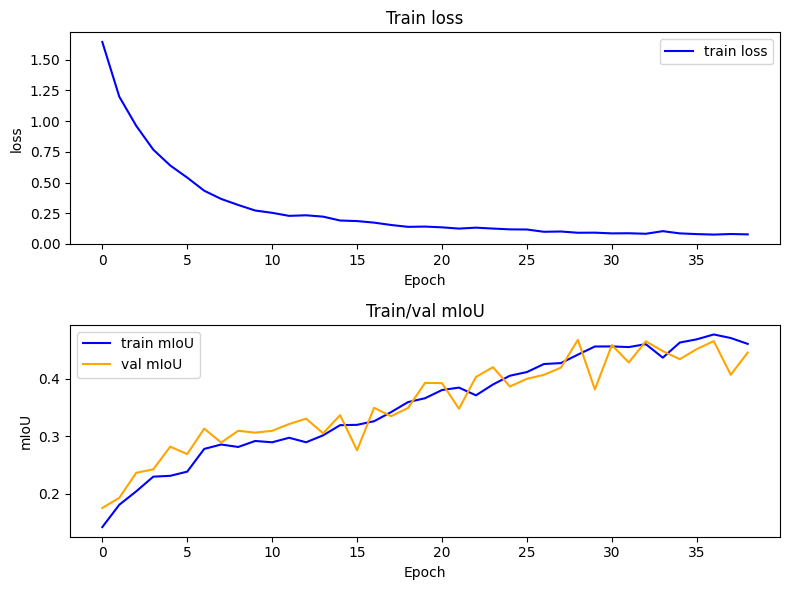

1999.0144474506378 s


In [ ]:
model1 =  Unet(9).to(device)
start_time = time.time()
train_with_center(model1,train_images_path,val_images_path,device,"/content/drive/MyDrive/dl/unet_final_50_epoch_1_4_lr_p_10_center.pth",50,1e-4,9,10)
end_time = time.time()
print(str(end_time-start_time)+" s")

Epoch 1
-------------------------------

 Train Loss: 1.2221601772844122, Val Loss: 0.8133571346600851, Train Acc: 0.968112587928772,Val Acc: 0.9875327348709106,
 Train IoU: 0.16471511125564575,Val IoU: 0.23127418756484985
Epoch 2
-------------------------------

 Train Loss: 0.8223034866740194, Val Loss: 0.6038440306981404, Train Acc: 0.9816099405288696,Val Acc: 0.9901047945022583,
 Train IoU: 0.2118176966905594,Val IoU: 0.24178345501422882
Epoch 3
-------------------------------

 Train Loss: 0.6307336992762062, Val Loss: 0.5076224853595098, Train Acc: 0.9849634170532227,Val Acc: 0.9900608658790588,
 Train IoU: 0.2280903160572052,Val IoU: 0.23372308909893036
Epoch 4
-------------------------------

 Train Loss: 0.49558472298504264, Val Loss: 0.38630339205265046, Train Acc: 0.9868374466896057,Val Acc: 0.9918811321258545,
 Train IoU: 0.23446621000766754,Val IoU: 0.2546035349369049
Epoch 5
-------------------------------

 Train Loss: 0.41471715455644587, Val Loss: 0.30460312267144524, 

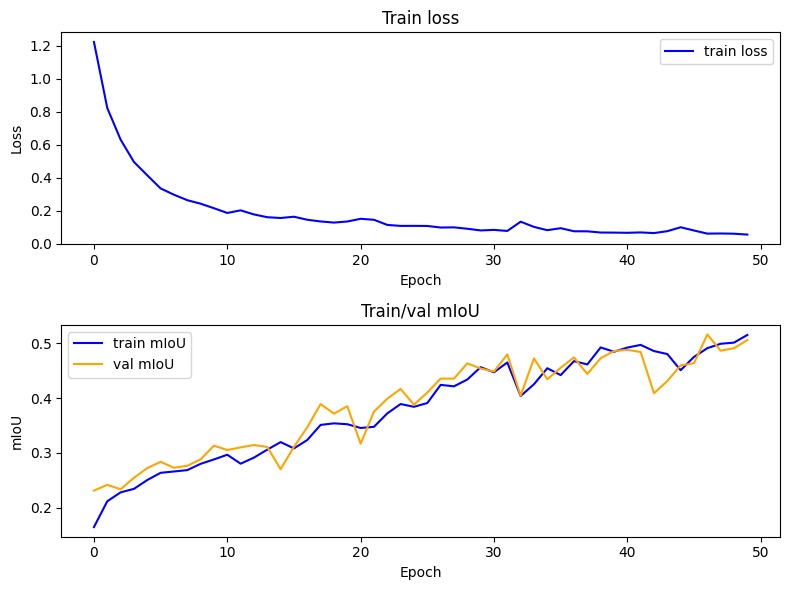

2589.3779451847076 s


In [ ]:
model1 =  Unet(9).to(device)
start_time = time.time()
train_with_lr_decay(model1,train_images_path,val_images_path,device,"/content/drive/MyDrive/dl/unet_final_50_epoch_1_4_lr_center_10p_lr_decay.pth",50,1e-4,9,patience=10)
end_time = time.time()
print(str(end_time-start_time)+" s")

###DeepLabv3Plus

In [ ]:
model3 =  Deeplabv3Plus(9).to(device)
start_time = time.time()
train_with_center(model3,train_images_path,val_images_path,device,"/content/drive/MyDrive/dl/deeplab_final_5_epoch_1_3_lr_center.pth",5,1e-3,9)
end_time = time.time()
print(str(end_time-start_time)+" s")

Epoch 1
-------------------------------

 Train Loss: 0.41907038472676544, Val Loss: 0.11926836942632993, Train Acc: 0.9772737622261047,Val Acc: 0.992495596408844,
 Train IoU: 0.22225266695022583,Val IoU: 0.35522183775901794
Epoch 2
-------------------------------

 Train Loss: 0.17446933397918604, Val Loss: 0.07840499567488829, Train Acc: 0.9880625009536743,Val Acc: 0.9949110150337219,
 Train IoU: 0.34979167580604553,Val IoU: 0.4097636342048645
Epoch 3
-------------------------------

 Train Loss: 0.10656222366215137, Val Loss: 0.07298735678195953, Train Acc: 0.9928128719329834,Val Acc: 0.9951574206352234,
 Train IoU: 0.4242624342441559,Val IoU: 0.42552682757377625
Epoch 4
-------------------------------

 Train Loss: 0.10916156024577912, Val Loss: 0.08253612406551838, Train Acc: 0.9927113652229309,Val Acc: 0.9940919876098633,
 Train IoU: 0.4375014305114746,Val IoU: 0.44745320081710815
Epoch 5
-------------------------------

 Train Loss: 0.07896397147704376, Val Loss: 0.0596999581282

In [ ]:
model3 =  Deeplabv3Plus(9).to(device)
start_time = time.time()
train_with_center(model3,train_images_path,val_images_path,device,"/content/drive/MyDrive/dl/deeplab_final_5_epoch_1_4_lr_center.pth",5,1e-4,9)
end_time = time.time()
print(str(end_time-start_time)+" s")

Epoch 1
-------------------------------

 Train Loss: 0.8408272832297208, Val Loss: 0.3254022687673569, Train Acc: 0.9721718430519104,Val Acc: 0.9928210973739624,
 Train IoU: 0.23719674348831177,Val IoU: 0.28588804602622986
Epoch 2
-------------------------------

 Train Loss: 0.31243503177433873, Val Loss: 0.1782690534989039, Train Acc: 0.9918410778045654,Val Acc: 0.9954283237457275,
 Train IoU: 0.3475794196128845,Val IoU: 0.4269738495349884
Epoch 3
-------------------------------

 Train Loss: 0.19653782223382693, Val Loss: 0.1288717436293761, Train Acc: 0.9941114783287048,Val Acc: 0.9959405660629272,
 Train IoU: 0.4753311276435852,Val IoU: 0.48556986451148987
Epoch 4
-------------------------------

 Train Loss: 0.1267548328202762, Val Loss: 0.11069469725092253, Train Acc: 0.9957425594329834,Val Acc: 0.996367335319519,
 Train IoU: 0.5384206175804138,Val IoU: 0.5191073417663574
Epoch 5
-------------------------------

 Train Loss: 0.09182763706599728, Val Loss: 0.07674037180840969, T

Epoch 1
-------------------------------

 Train Loss: 0.7536143188396197, Val Loss: 0.25981993675231935, Train Acc: 0.9766251444816589,Val Acc: 0.9938979744911194,
 Train IoU: 0.24860744178295135,Val IoU: 0.33221668004989624
Epoch 2
-------------------------------

 Train Loss: 0.27437750961673396, Val Loss: 0.15118223130702974, Train Acc: 0.9924048781394958,Val Acc: 0.9956643581390381,
 Train IoU: 0.38212850689888,Val IoU: 0.4377521276473999
Epoch 3
-------------------------------

 Train Loss: 0.15310665437679613, Val Loss: 0.10934884995222091, Train Acc: 0.9955427050590515,Val Acc: 0.9958610534667969,
 Train IoU: 0.5081725716590881,Val IoU: 0.4772721827030182
Epoch 4
-------------------------------

 Train Loss: 0.10342266942175586, Val Loss: 0.10103358676036199, Train Acc: 0.9966252446174622,Val Acc: 0.9959452748298645,
 Train IoU: 0.5617708563804626,Val IoU: 0.5218082666397095
Epoch 5
-------------------------------

 Train Loss: 0.07372288757495665, Val Loss: 0.06895779644449553,

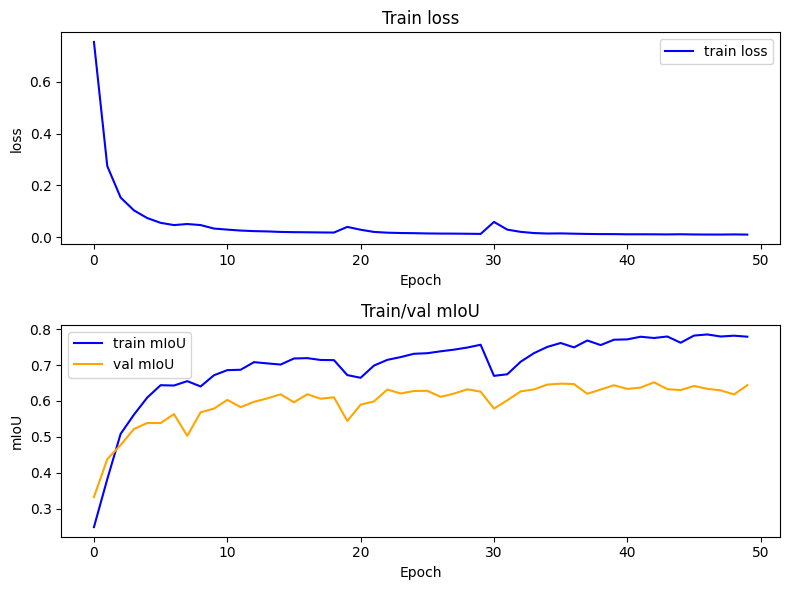

1143.6707911491394 s


In [ ]:
model3 =  Deeplabv3Plus(9).to(device)
start_time = time.time()
train_with_center(model3,train_images_path,val_images_path,device,"/content/drive/MyDrive/dl/deeplab_final_50_epoch_1_4_lr_center_10P.pth",50,1e-4,9,patience=10)
end_time = time.time()
print(str(end_time-start_time)+" s")

Epoch 1
-------------------------------

 Train Loss: 0.8656129914053371, Val Loss: 0.3069678495327632, Train Acc: 0.97458416223526,Val Acc: 0.9934635758399963,
 Train IoU: 0.22482141852378845,Val IoU: 0.28660470247268677
Epoch 2
-------------------------------

 Train Loss: 0.32636301487349395, Val Loss: 0.21837663054466247, Train Acc: 0.9910287261009216,Val Acc: 0.9947413802146912,
 Train IoU: 0.3084690272808075,Val IoU: 0.35428228974342346
Epoch 3
-------------------------------

 Train Loss: 0.18085656273231077, Val Loss: 0.11809225628773372, Train Acc: 0.9946873784065247,Val Acc: 0.9960379004478455,
 Train IoU: 0.4433428645133972,Val IoU: 0.49032747745513916
Epoch 4
-------------------------------

 Train Loss: 0.12099130811651101, Val Loss: 0.08816424583395323, Train Acc: 0.9961901903152466,Val Acc: 0.9964511394500732,
 Train IoU: 0.5252197980880737,Val IoU: 0.48896199464797974
Epoch 5
-------------------------------

 Train Loss: 0.0841455367090327, Val Loss: 0.07891809480885664

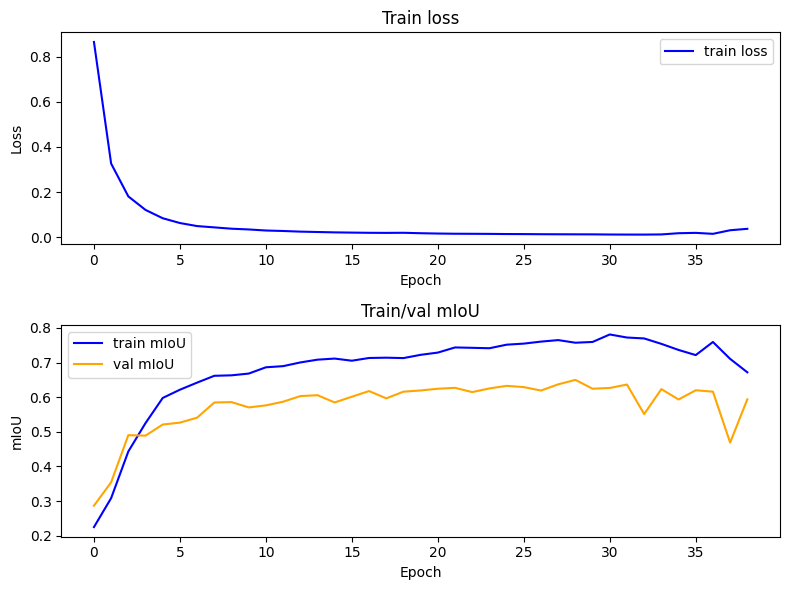

987.0252571105957 s


In [ ]:
model3 =  Deeplabv3Plus(9).to(device)
start_time = time.time()
train_with_lr_decay(model3,train_images_path,val_images_path,device,"/content/drive/MyDrive/dl/deeplab_final_50_epoch_1_4_lr_center_10p_lr_decay.pth",50,1e-4,9,patience=10)
end_time = time.time()
print(str(end_time-start_time)+" s")

###SegNet

In [ ]:
model2 =  SegNet(9).to(device)
train_with_center(model2,train_images_path,val_images_path,device,"/content/drive/MyDrive/dl/segnet_final_5_epoch_1_4_lr_center.pth",5,1e-4,9)

Epoch 1
-------------------------------

 Train Loss: 1.0955917420012227, Val Loss: 0.364225306113561, Train Acc: 0.943324089050293,Val Acc: 0.9860782027244568,
 Train IoU: 0.12250146269798279,Val IoU: 0.1823701709508896
Epoch 2
-------------------------------

 Train Loss: 0.3814460427573558, Val Loss: 0.23770624895890555, Train Acc: 0.9809642434120178,Val Acc: 0.9892554879188538,
 Train IoU: 0.16578792035579681,Val IoU: 0.19270887970924377
Epoch 3
-------------------------------

 Train Loss: 0.32349825173281554, Val Loss: 0.3275893042484919, Train Acc: 0.9795316457748413,Val Acc: 0.975755512714386,
 Train IoU: 0.17149898409843445,Val IoU: 0.15800626575946808
Epoch 4
-------------------------------

 Train Loss: 0.29514642210488906, Val Loss: 0.2063943530122439, Train Acc: 0.9818270206451416,Val Acc: 0.9846838116645813,
 Train IoU: 0.18688449263572693,Val IoU: 0.20980922877788544
Epoch 5
-------------------------------

 Train Loss: 0.2310992716236061, Val Loss: 0.17178035552302998, 

In [ ]:
model2 =  SegNet(9).to(device)
train_with_center(model2,train_images_path,val_images_path,device,"/content/drive/MyDrive/dl/segnet_final_5_epoch_1_3_lr_center.pth",5,1e-3,9)

Epoch 1
-------------------------------

 Train Loss: 0.6997921624210444, Val Loss: 0.38803106745084126, Train Acc: 0.9584527015686035,Val Acc: 0.9724374413490295,
 Train IoU: 0.09580585360527039,Val IoU: 0.11928408592939377
Epoch 2
-------------------------------

 Train Loss: 0.4652356478605377, Val Loss: 0.4289488285779953, Train Acc: 0.9653169512748718,Val Acc: 0.9685037732124329,
 Train IoU: 0.11480670422315598,Val IoU: 0.13342374563217163
Epoch 3
-------------------------------

 Train Loss: 0.44404677544417004, Val Loss: 0.37442507147789, Train Acc: 0.9659867286682129,Val Acc: 0.9705913066864014,
 Train IoU: 0.1249917522072792,Val IoU: 0.11894462257623672
Epoch 4
-------------------------------

 Train Loss: 0.3926702598842342, Val Loss: 0.25103256752093633, Train Acc: 0.9716069102287292,Val Acc: 0.9820650219917297,
 Train IoU: 0.15240171551704407,Val IoU: 0.20163494348526
Epoch 5
-------------------------------

 Train Loss: 0.40449022878421825, Val Loss: 0.2832542965809504, Tr

Epoch 1
-------------------------------

 Train Loss: 1.091978352391318, Val Loss: 0.33853921095530193, Train Acc: 0.9465030431747437,Val Acc: 0.9876582622528076,
 Train IoU: 0.12780940532684326,Val IoU: 0.1745375692844391
Epoch 2
-------------------------------

 Train Loss: 0.435139828016249, Val Loss: 0.25838697254657744, Train Acc: 0.9732268452644348,Val Acc: 0.9875457286834717,
 Train IoU: 0.1507994383573532,Val IoU: 0.18435393273830414
Epoch 3
-------------------------------

 Train Loss: 0.3444197792350576, Val Loss: 0.24804728577534357, Train Acc: 0.9770399928092957,Val Acc: 0.9826783537864685,
 Train IoU: 0.1597227156162262,Val IoU: 0.16683685779571533
Epoch 4
-------------------------------

 Train Loss: 0.3152214290385836, Val Loss: 0.20973612368106842, Train Acc: 0.9775745868682861,Val Acc: 0.985674262046814,
 Train IoU: 0.16461411118507385,Val IoU: 0.19546864926815033
Epoch 5
-------------------------------

 Train Loss: 0.2678188775362593, Val Loss: 0.2090336280564467, Tr

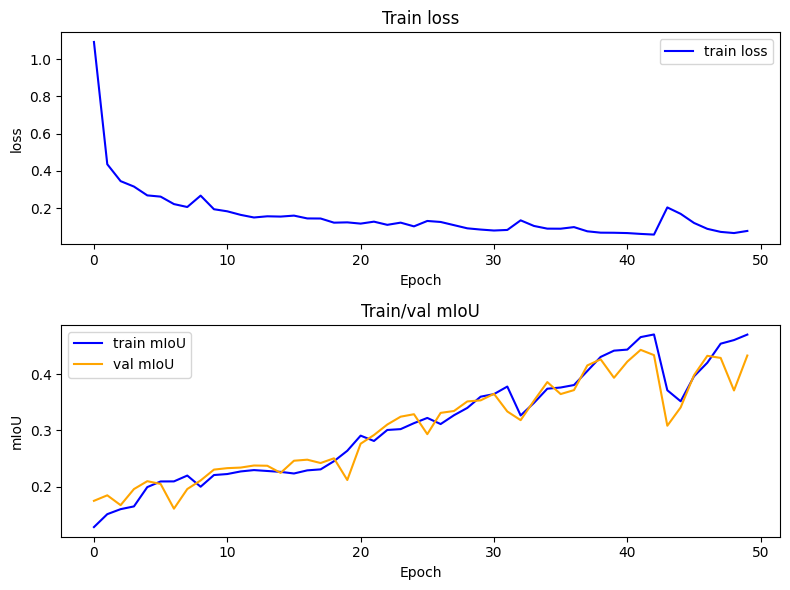

In [ ]:
model2 =  SegNet(9).to(device)
train_with_center(model2,train_images_path,val_images_path,device,"/content/drive/MyDrive/dl/segnet_final_50_epoch_1_4_lr_center_10p.pth",50,1e-4,9,patience=10)

Epoch 1
-------------------------------

 Train Loss: 1.261197918251659, Val Loss: 0.42866814831892647, Train Acc: 0.9349063634872437,Val Acc: 0.9778023958206177,
 Train IoU: 0.11268211156129837,Val IoU: 0.1472117006778717
Epoch 2
-------------------------------

 Train Loss: 0.4161184135447727, Val Loss: 0.2993614966670672, Train Acc: 0.9741865396499634,Val Acc: 0.983065664768219,
 Train IoU: 0.14887700974941254,Val IoU: 0.16935835778713226
Epoch 3
-------------------------------

 Train Loss: 0.337879532341207, Val Loss: 0.3426689823468526, Train Acc: 0.9765225648880005,Val Acc: 0.9777622222900391,
 Train IoU: 0.15891210734844208,Val IoU: 0.17946720123291016
Epoch 4
-------------------------------

 Train Loss: 0.28994054707248557, Val Loss: 0.22361536224683126, Train Acc: 0.9807258248329163,Val Acc: 0.9858479499816895,
 Train IoU: 0.1934310346841812,Val IoU: 0.20738281309604645
Epoch 5
-------------------------------

 Train Loss: 0.2553543091824885, Val Loss: 0.3147293098270893, Tr

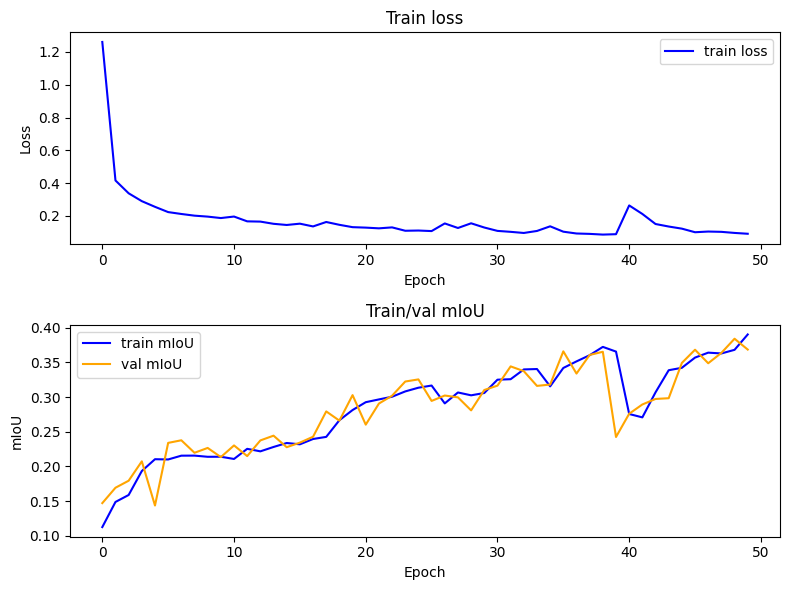

2044.8225646018982 s


In [ ]:
model2 =  SegNet(9).to(device)
start_time = time.time()
train_with_lr_decay(model2,train_images_path,val_images_path,device,"/content/drive/MyDrive/dl/segnet_final_50_epoch_1_4_lr_center_10p_lr_decay.pth",50,1e-4,9,patience=10)
end_time = time.time()
print(str(end_time-start_time)+" s")

##Testiranje


###Unet

In [ ]:
model_test_1 = Unet(9).to(device)

In [ ]:
model_test_1.load_state_dict(torch.load("/content/drive/MyDrive/dl/unet_final_50_epoch_1_4_lr_p_10_center.pth"))

<All keys matched successfully>

 Test Loss: 0.09846309584875902, Test Acc: 0.9935802817344666, Test IoU: 0.3917863070964813
 Test Precision: 0.4812546372413635, Test Recall: 0.4521864056587219, Test f1: 0.45003023743629456


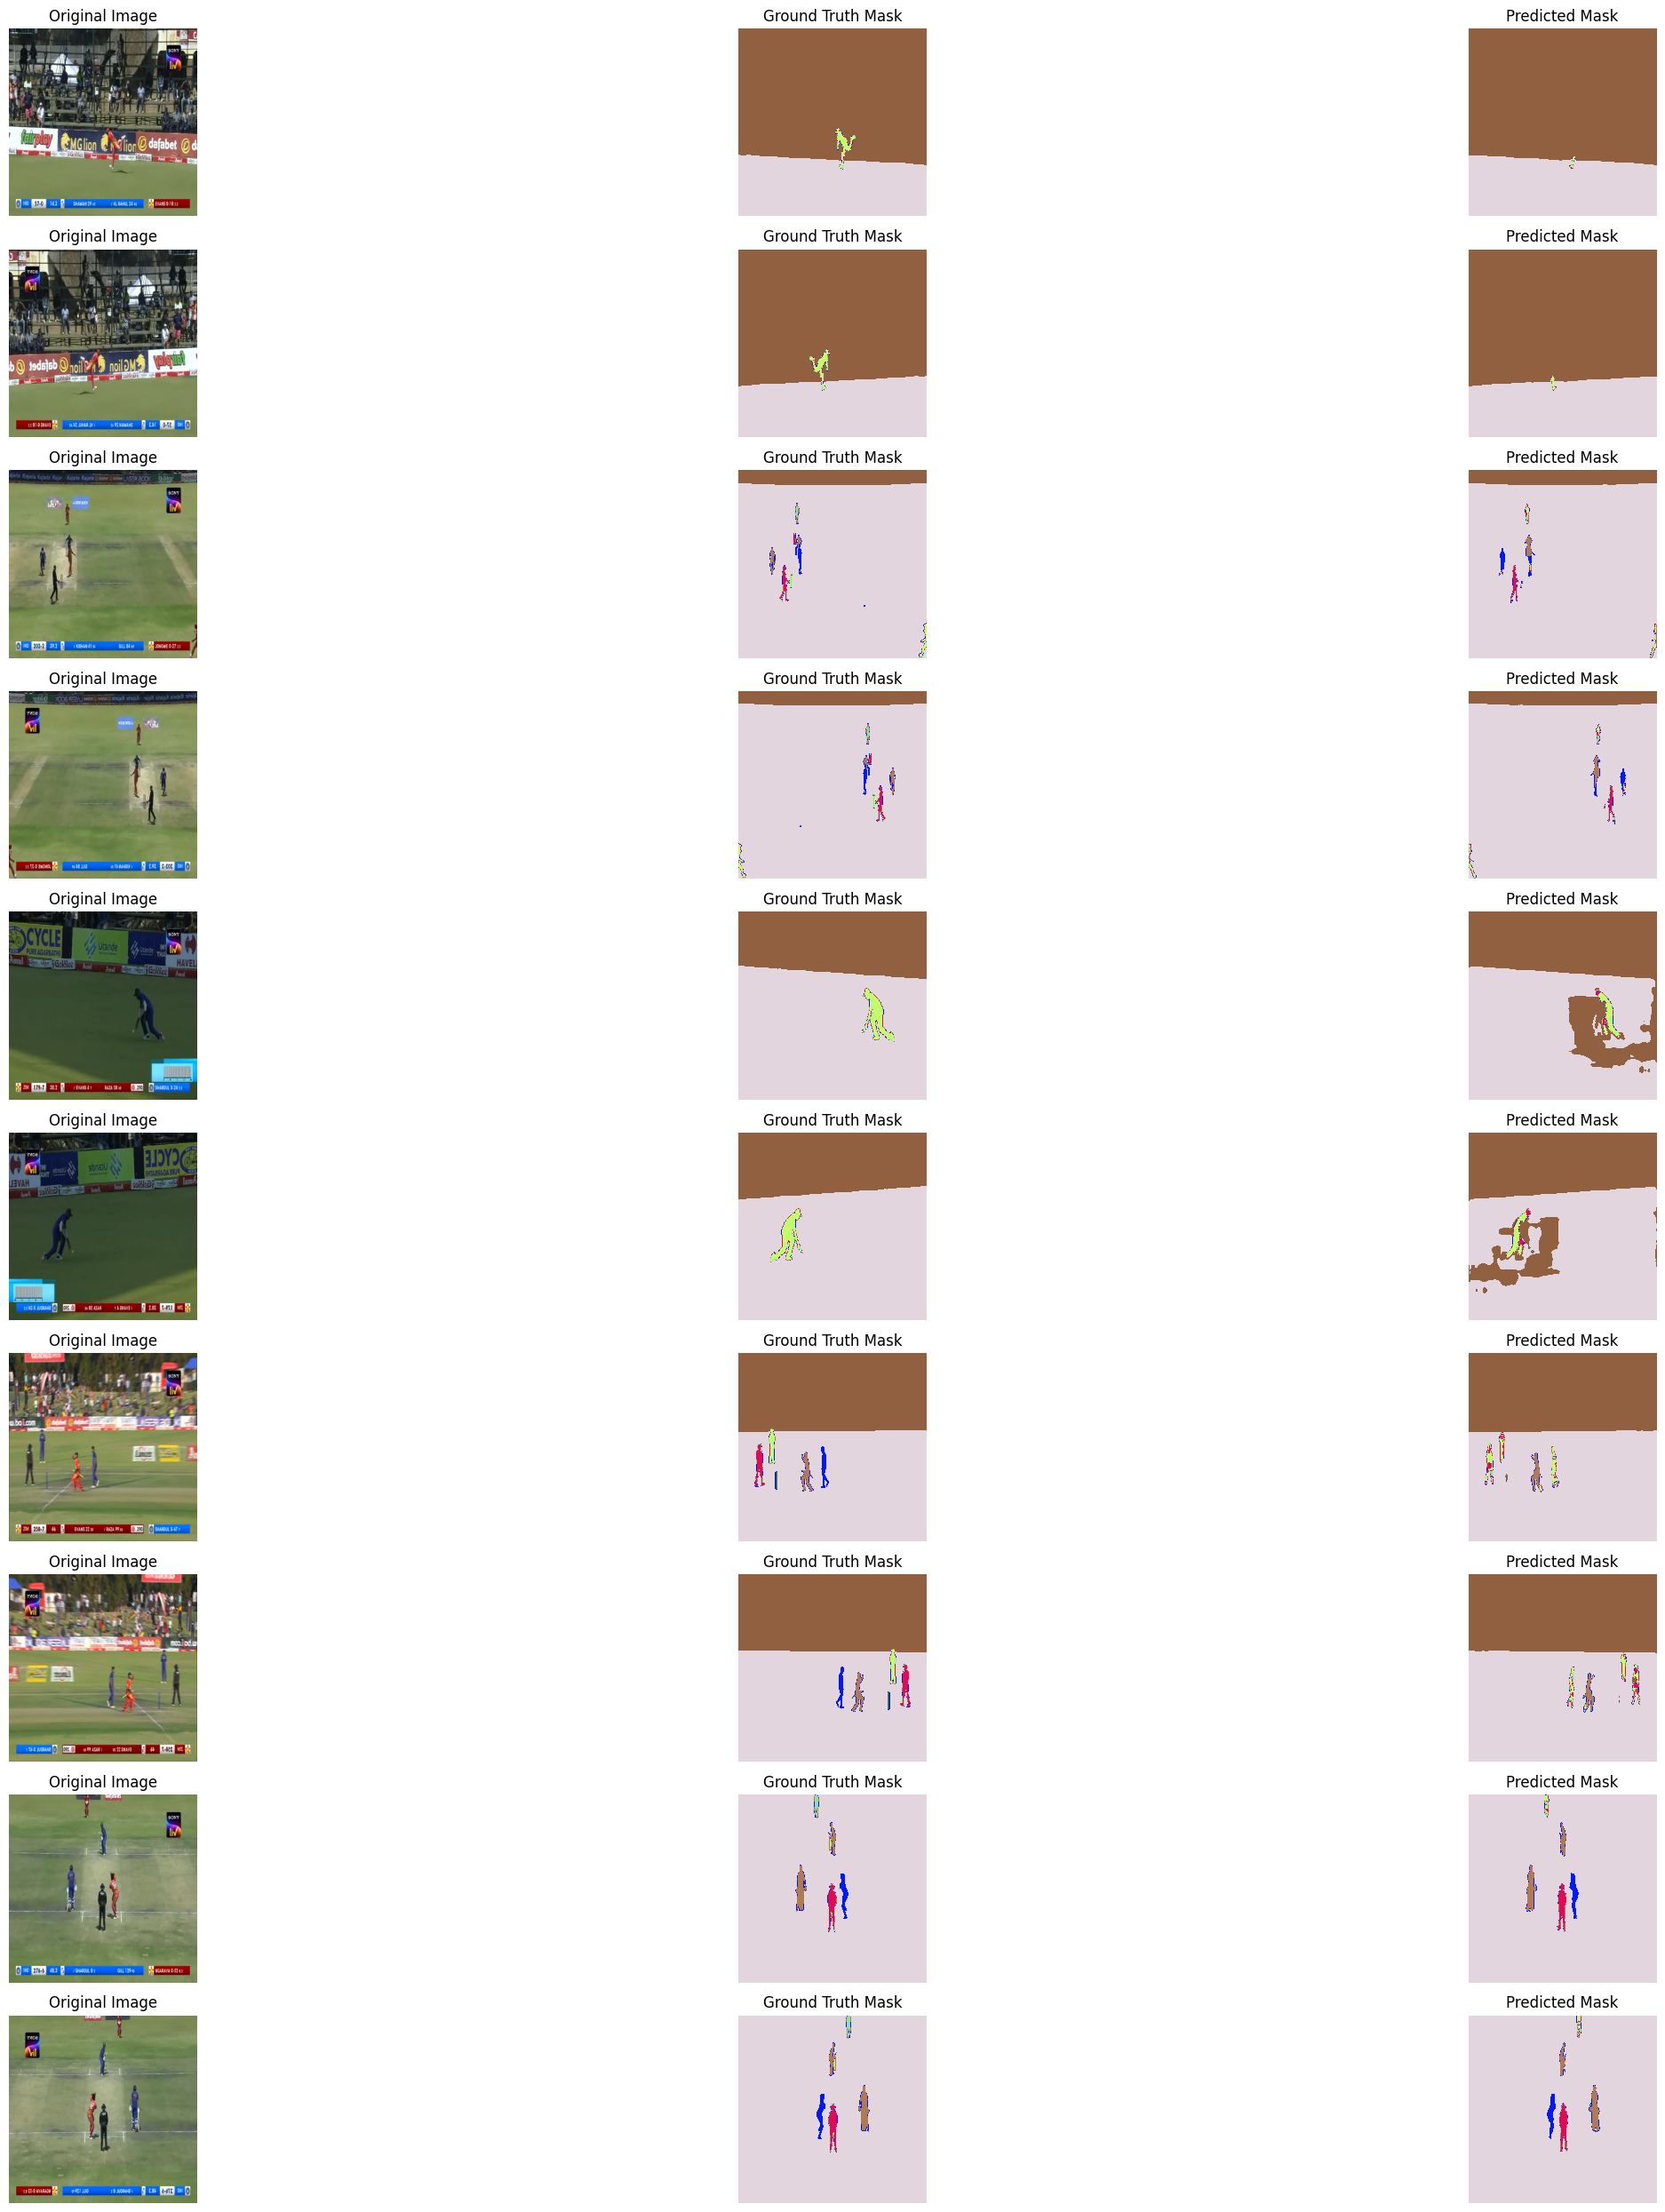

In [ ]:
test_center(model_test_1,test_images_path,device,9)

 Test Loss: 0.08930953380962213, Test Acc: 0.9940549731254578, Test IoU: 0.41710588335990906
 Test Precision: 0.5053137540817261, Test Recall: 0.4732781648635864, Test f1: 0.4693557024002075


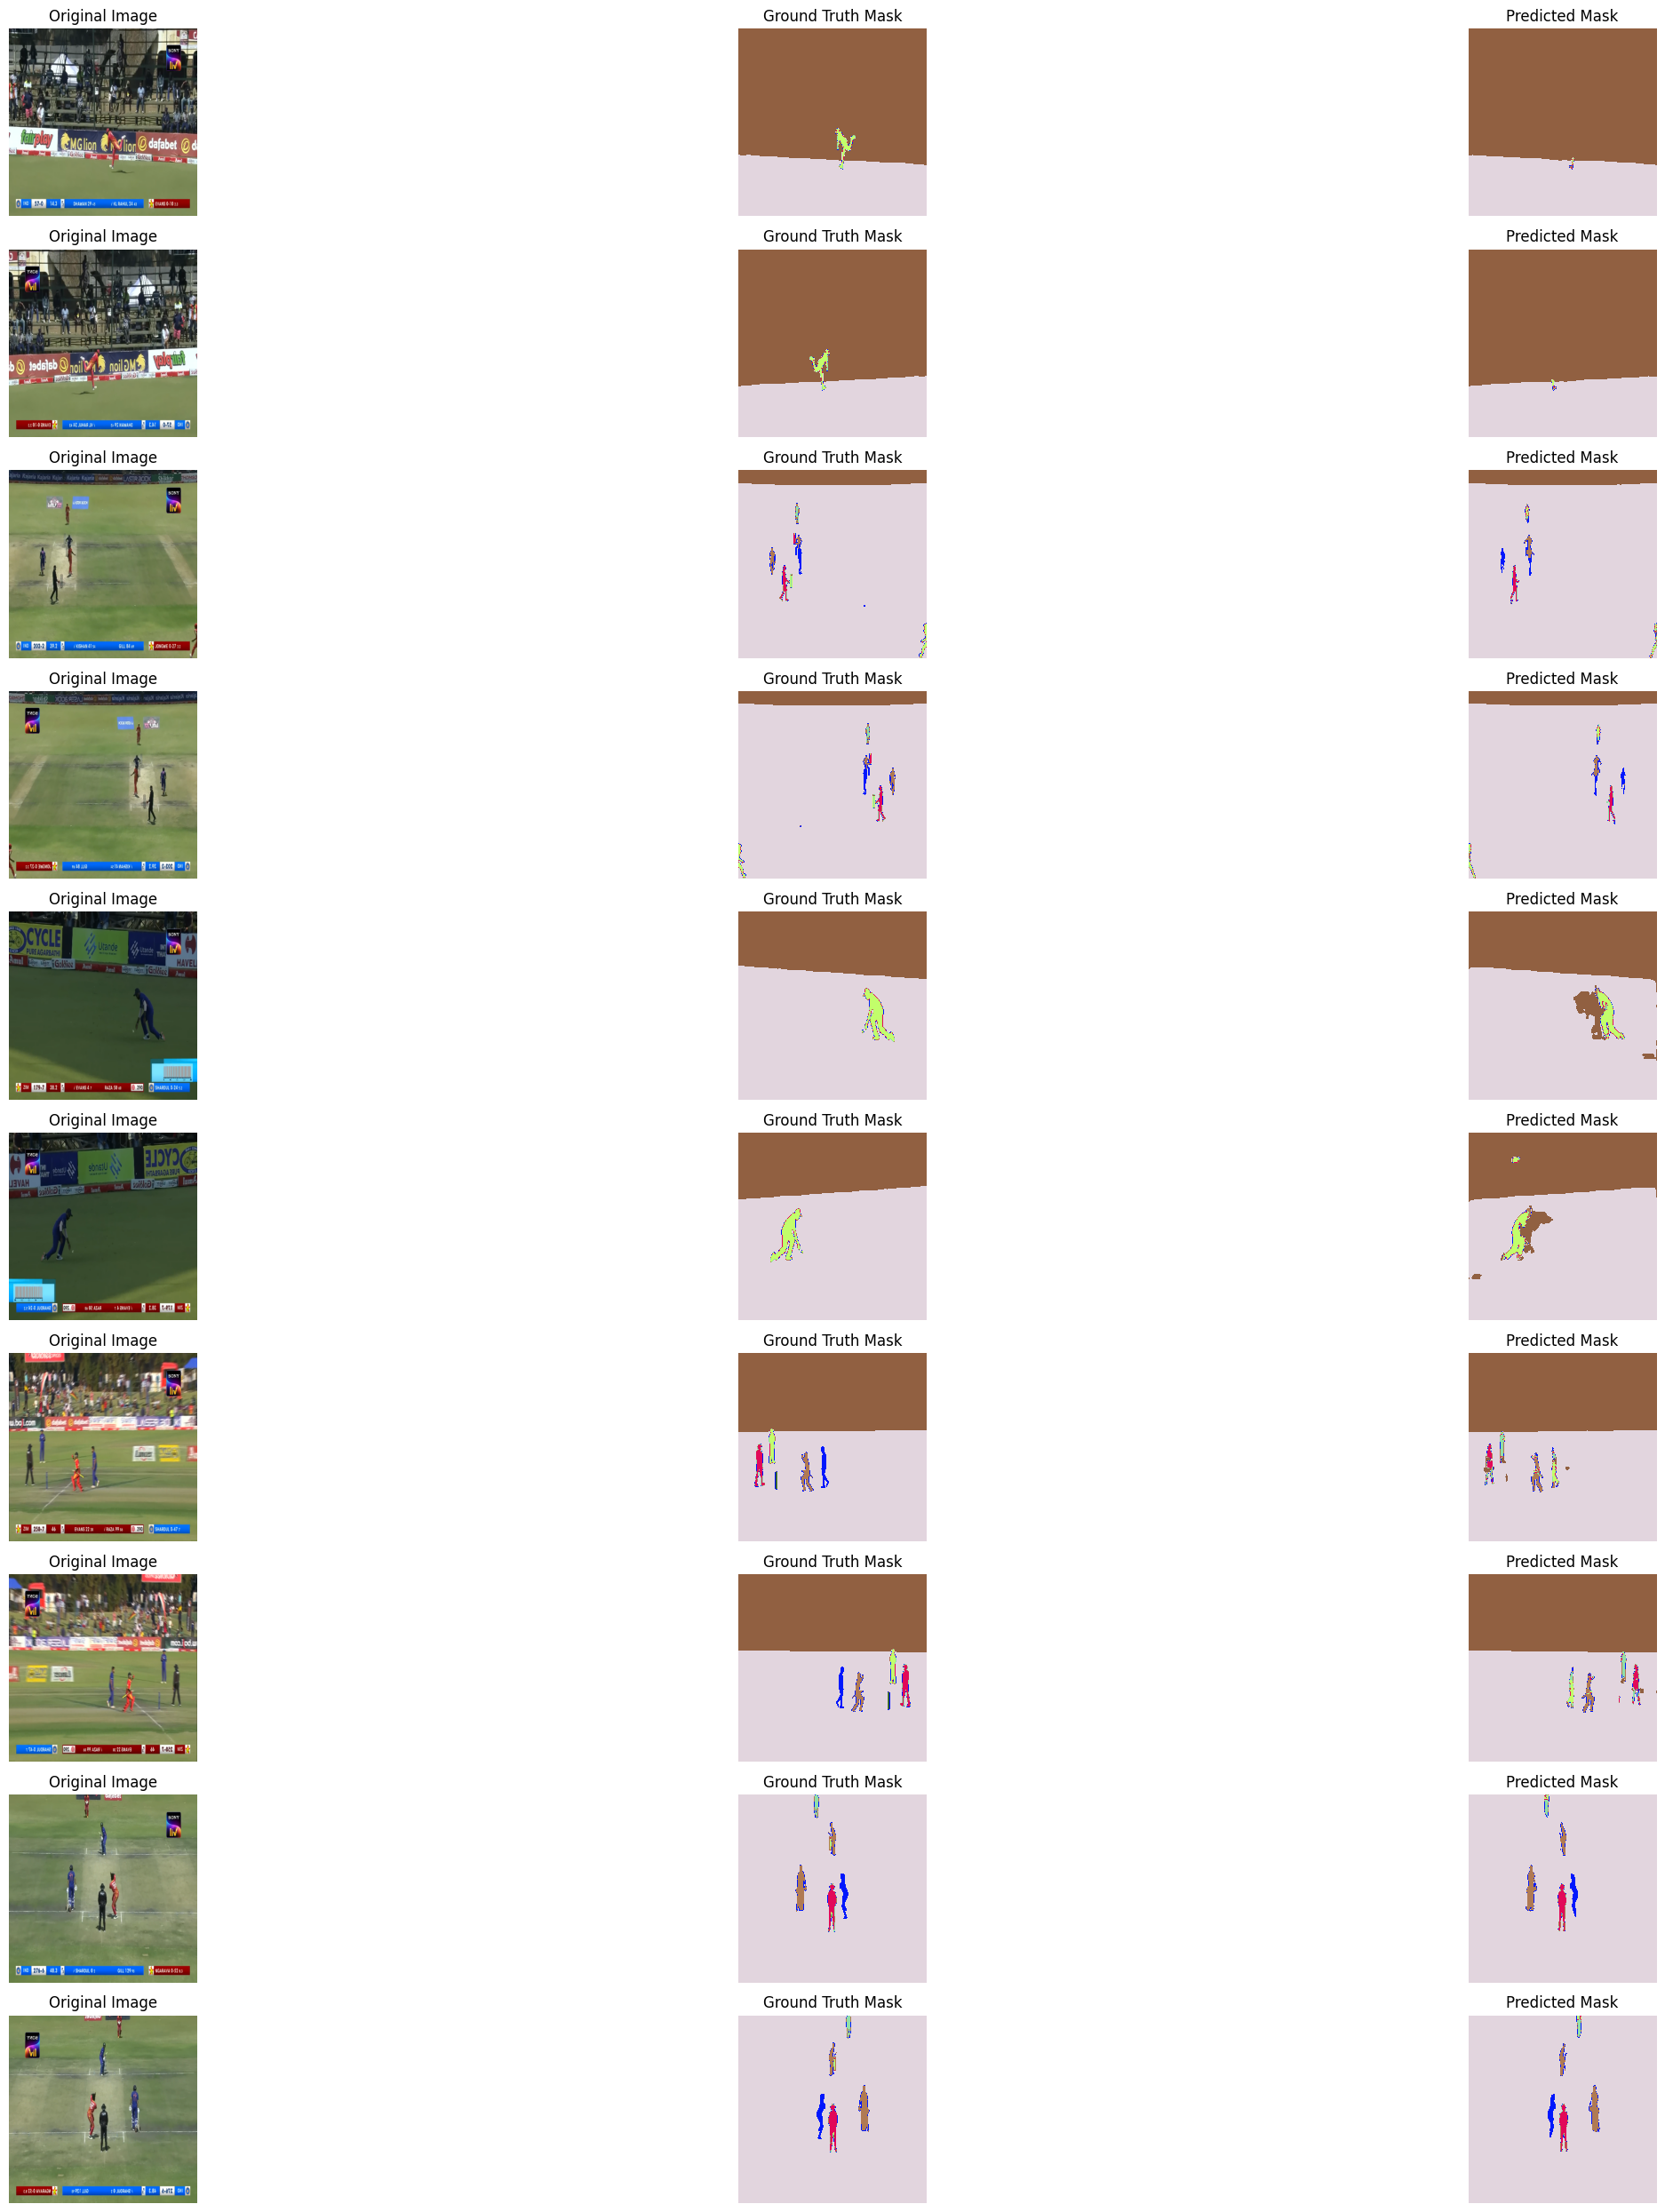

In [ ]:
model_test_1 = Unet(9).to(device)
model_test_1.load_state_dict(torch.load("/content/drive/MyDrive/dl/unet_final_50_epoch_1_4_lr_center_10p_lr_decay.pth"))
test_center(model_test_1,test_images_path,device,9)

###DeepLabv3Plus

In [ ]:
model_test_2 = Deeplabv3Plus(9).to(device)
model_test_2.load_state_dict(torch.load("/content/drive/MyDrive/dl/deeplab_final_50_epoch_1_4_lr_center_10P.pth"))

<All keys matched successfully>

 Test Loss: 0.03363226453463237, Test Acc: 0.9976621270179749, Test IoU: 0.5631610751152039
 Test Precision: 0.6766265034675598, Test Recall: 0.6048035025596619, Test f1: 0.6197536587715149


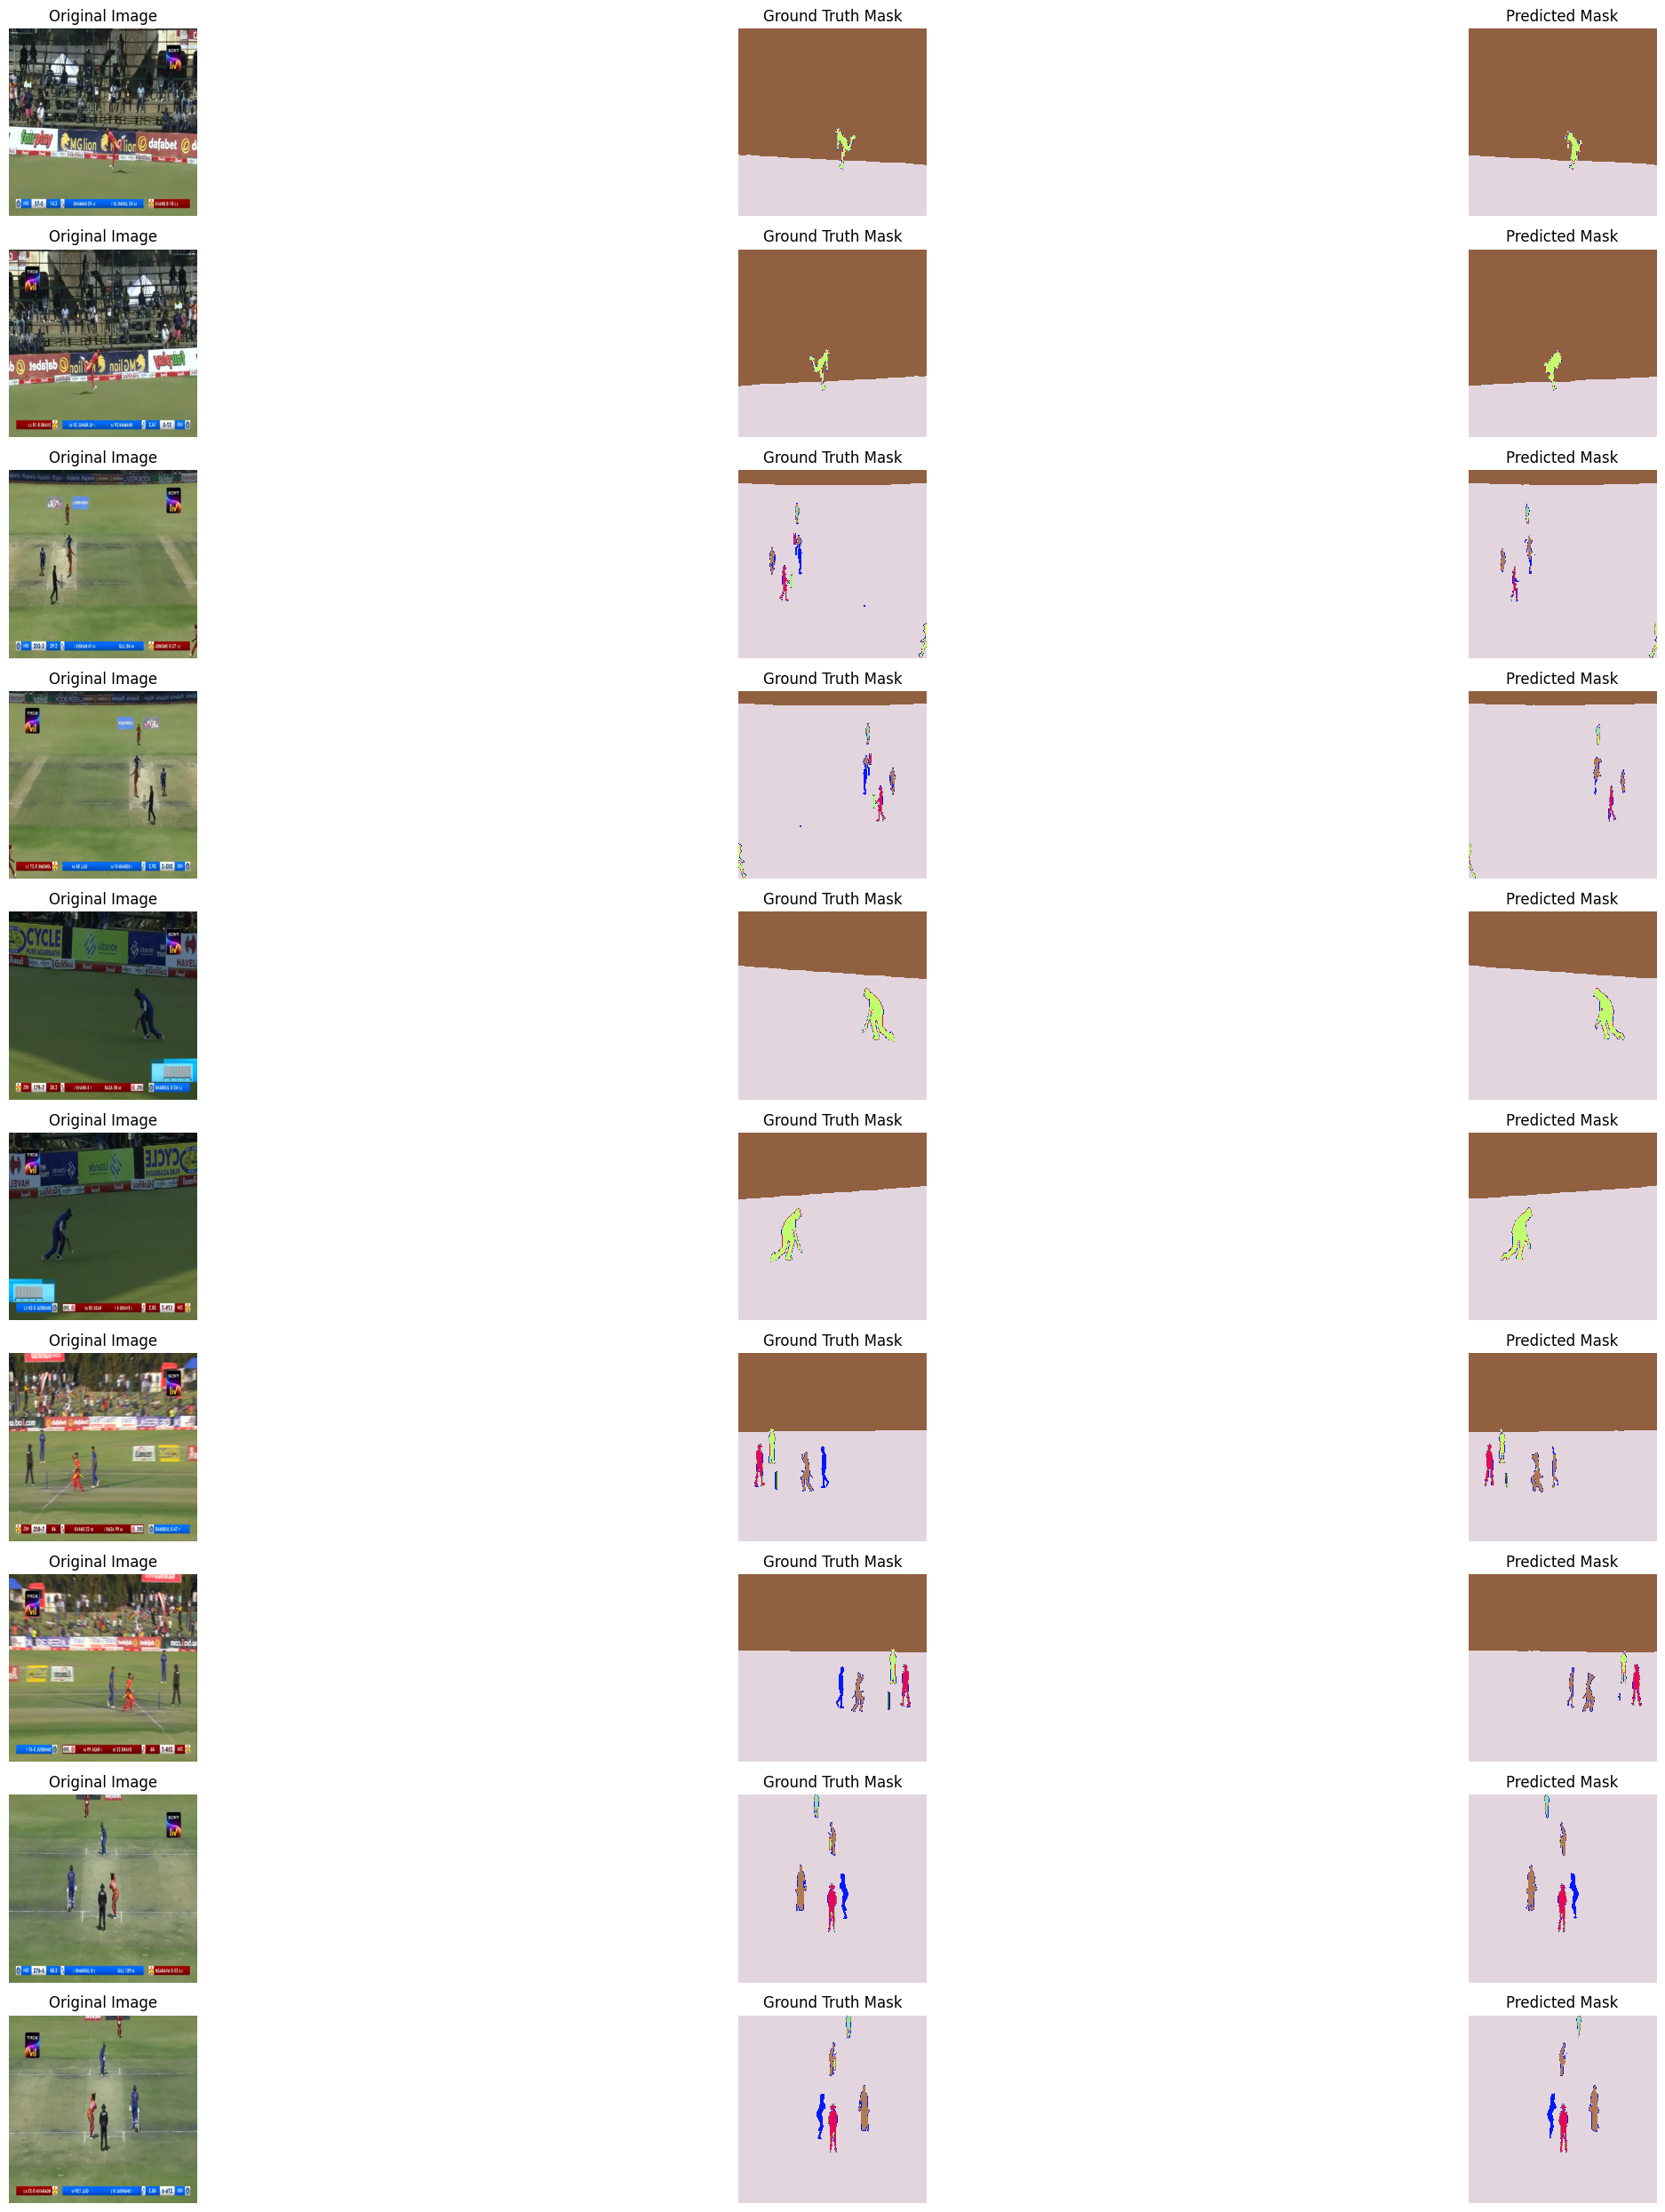

In [ ]:
test_center(model_test_2,test_images_path,device,9)

In [ ]:

model_test_2 = Deeplabv3Plus(9).to(device)
model_test_2.load_state_dict(torch.load("/content/drive/MyDrive/dl/deeplab_final_50_epoch_1_4_lr_center_10p_lr_decay.pth"))


<All keys matched successfully>

 Test Loss: 0.037615182964752115, Test Acc: 0.9974334239959717, Test IoU: 0.5662978887557983
 Test Precision: 0.6712557077407837, Test Recall: 0.610623300075531, Test f1: 0.6237319707870483


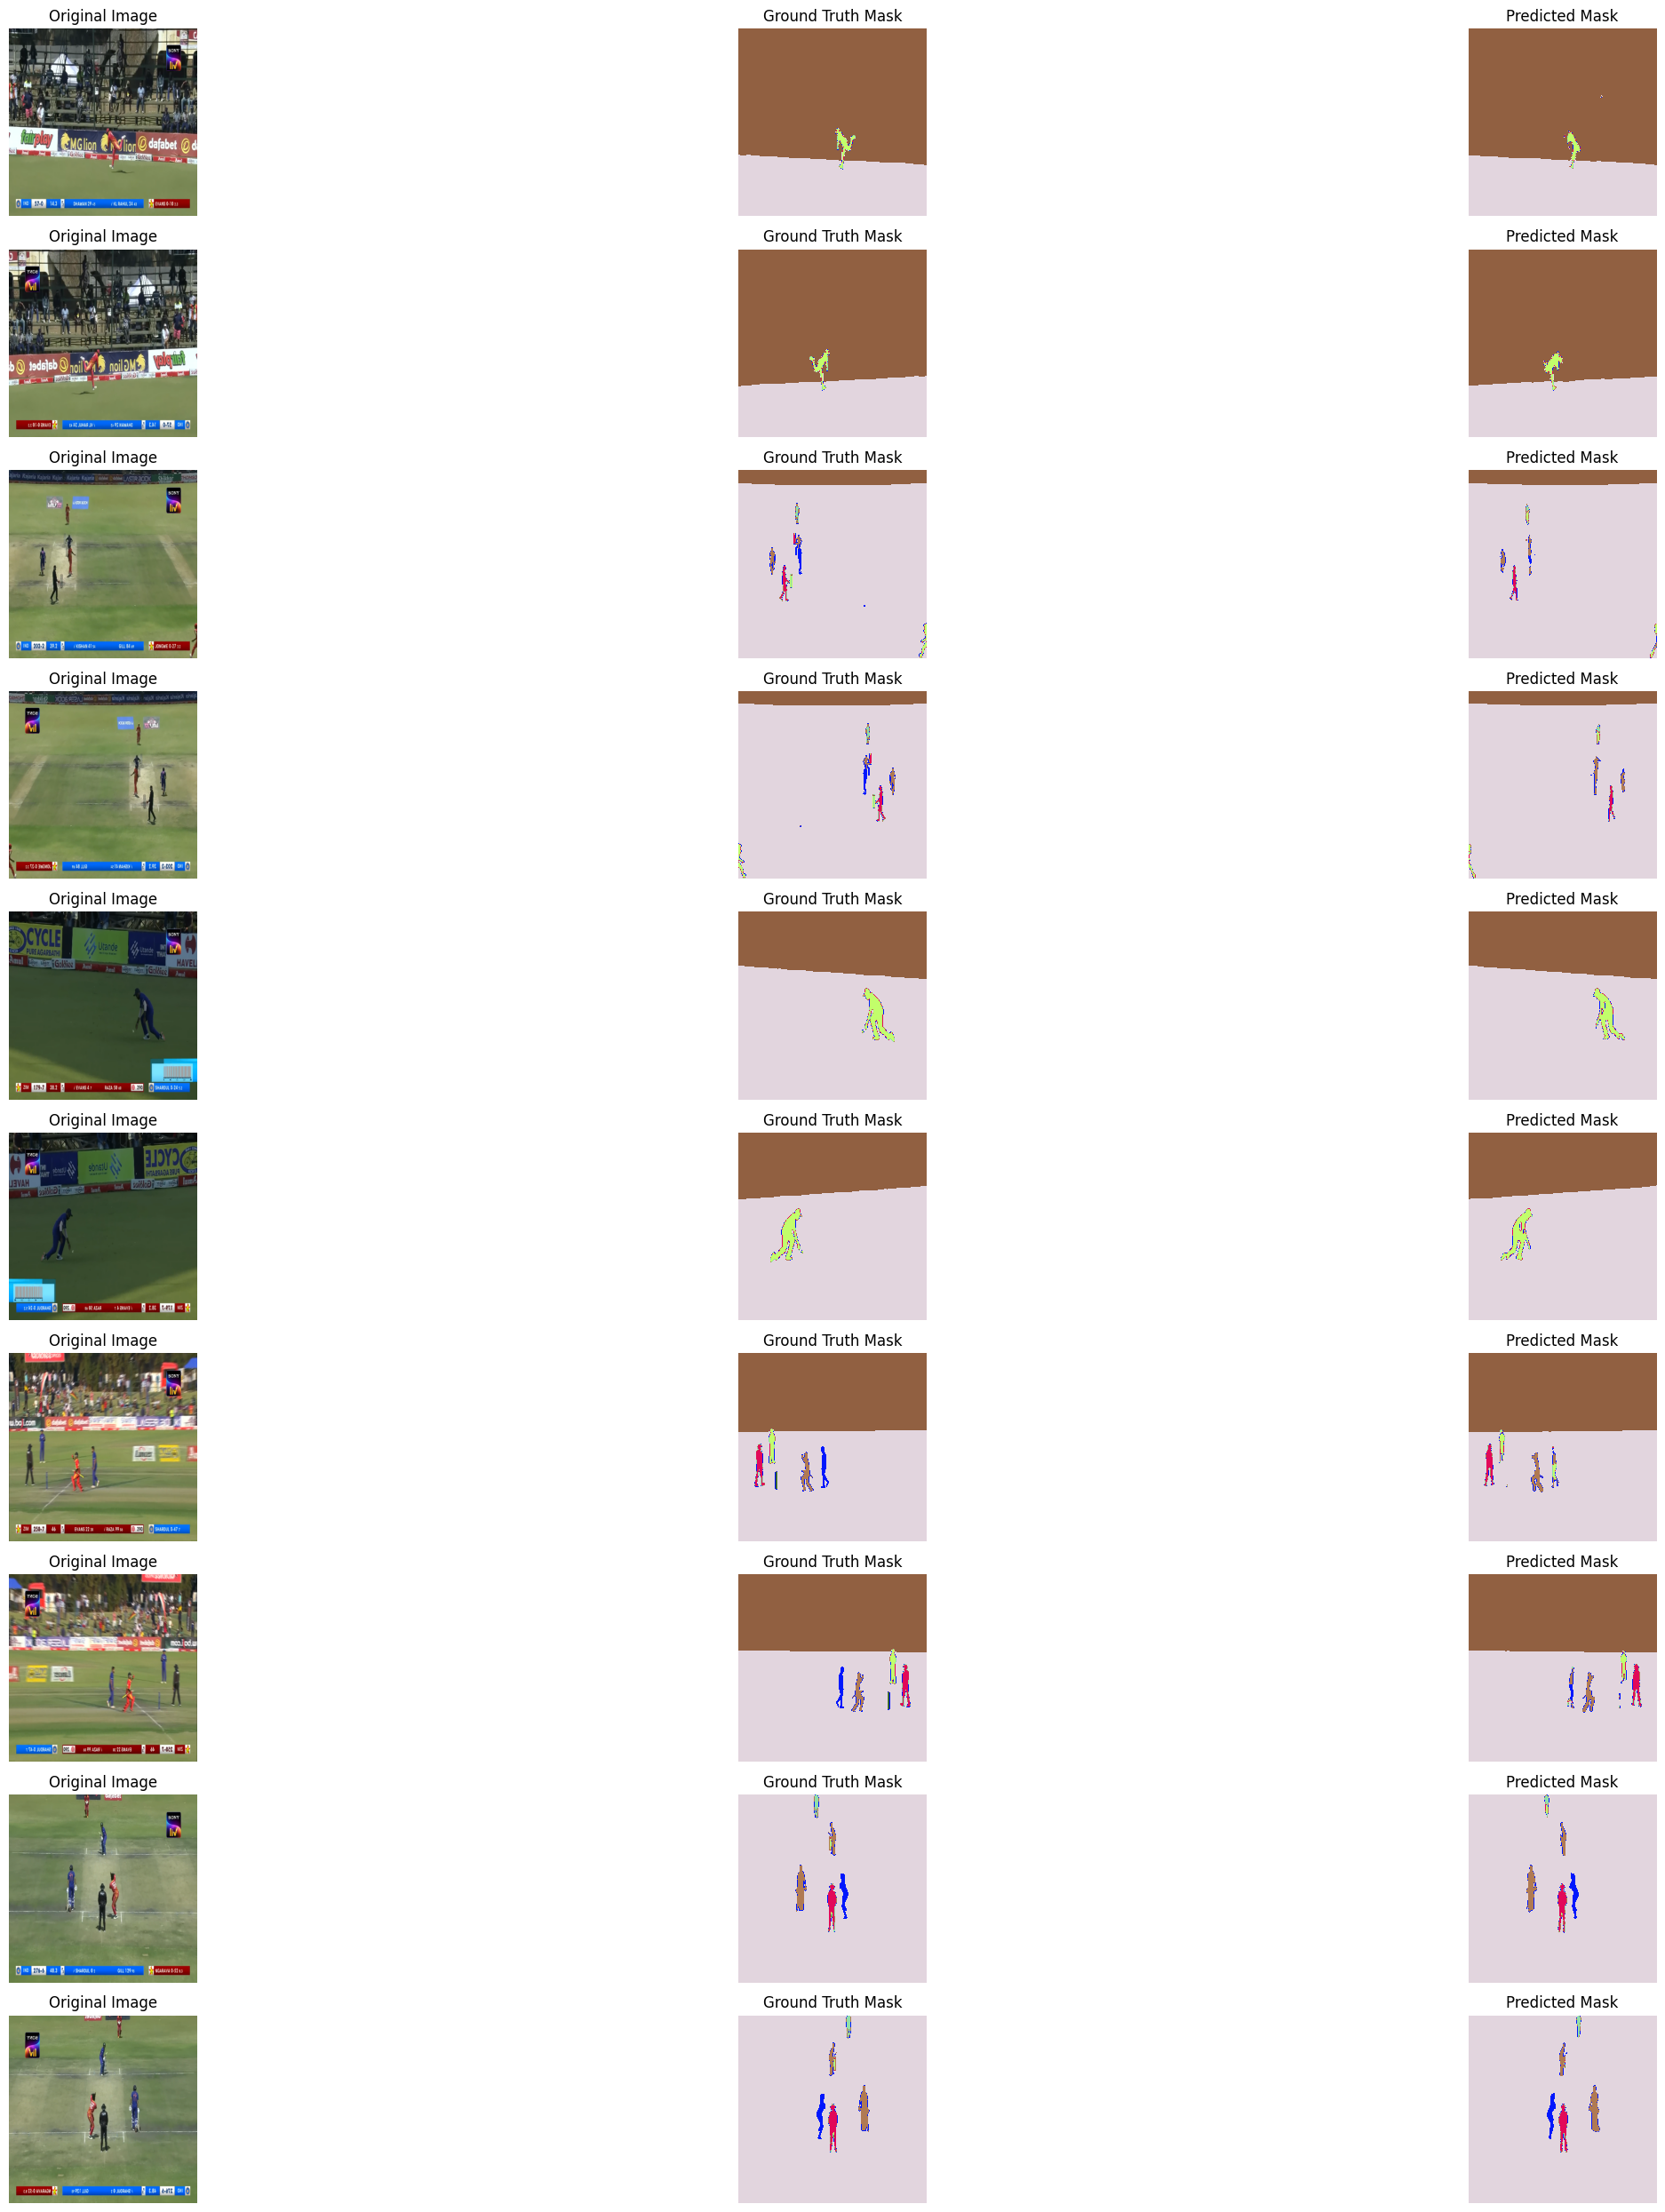

In [ ]:
test_center(model_test_2,test_images_path,device,9)

###Segnet

In [ ]:
model_test_3 = SegNet(9).to(device)
model_test_3.load_state_dict(torch.load("/content/drive/MyDrive/dl/segnet_final_50_epoch_1_4_lr_center_10p.pth"))

<All keys matched successfully>

 Test Loss: 0.14130224206795294, Test Acc: 0.9912574887275696, Test IoU: 0.3689473569393158
 Test Precision: 0.4581528306007385, Test Recall: 0.45369985699653625, Test f1: 0.43113595247268677


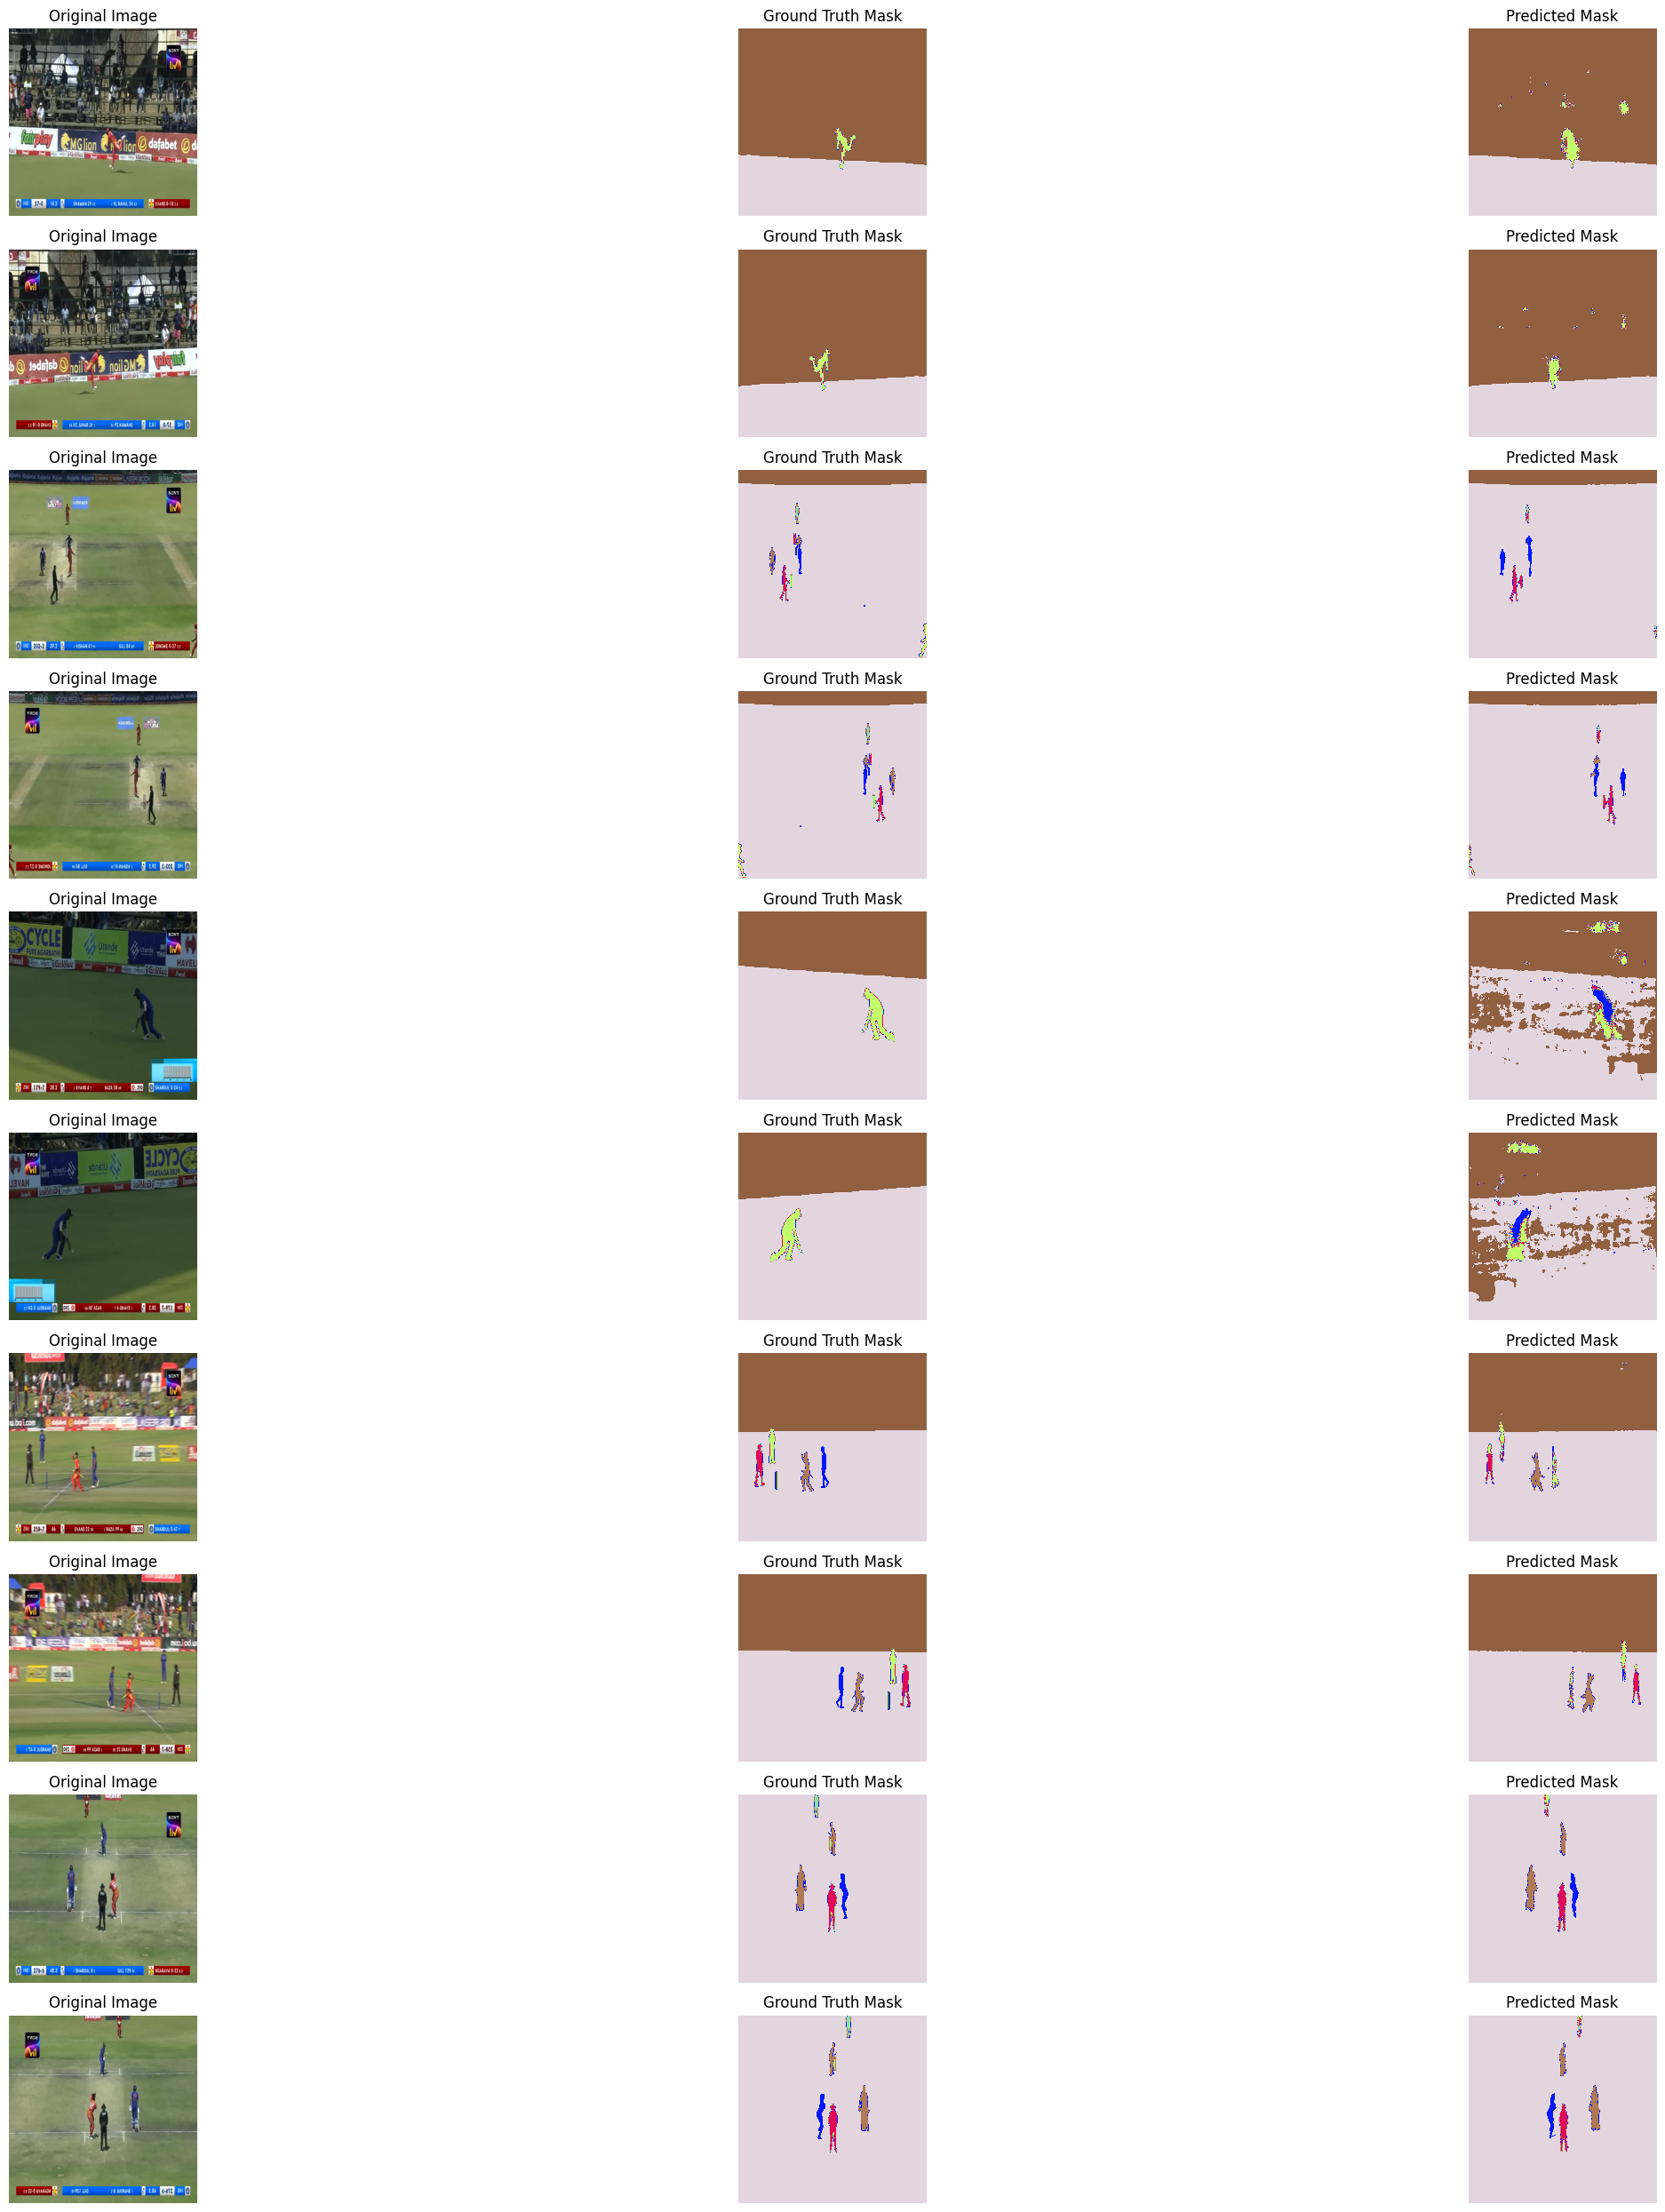

In [ ]:
test_center(model_test_3,test_images_path,device,9)

 Test Loss: 0.13615430841843287, Test Acc: 0.9905080199241638, Test IoU: 0.32773613929748535
 Test Precision: 0.42726072669029236, Test Recall: 0.4016108810901642, Test f1: 0.3801450729370117


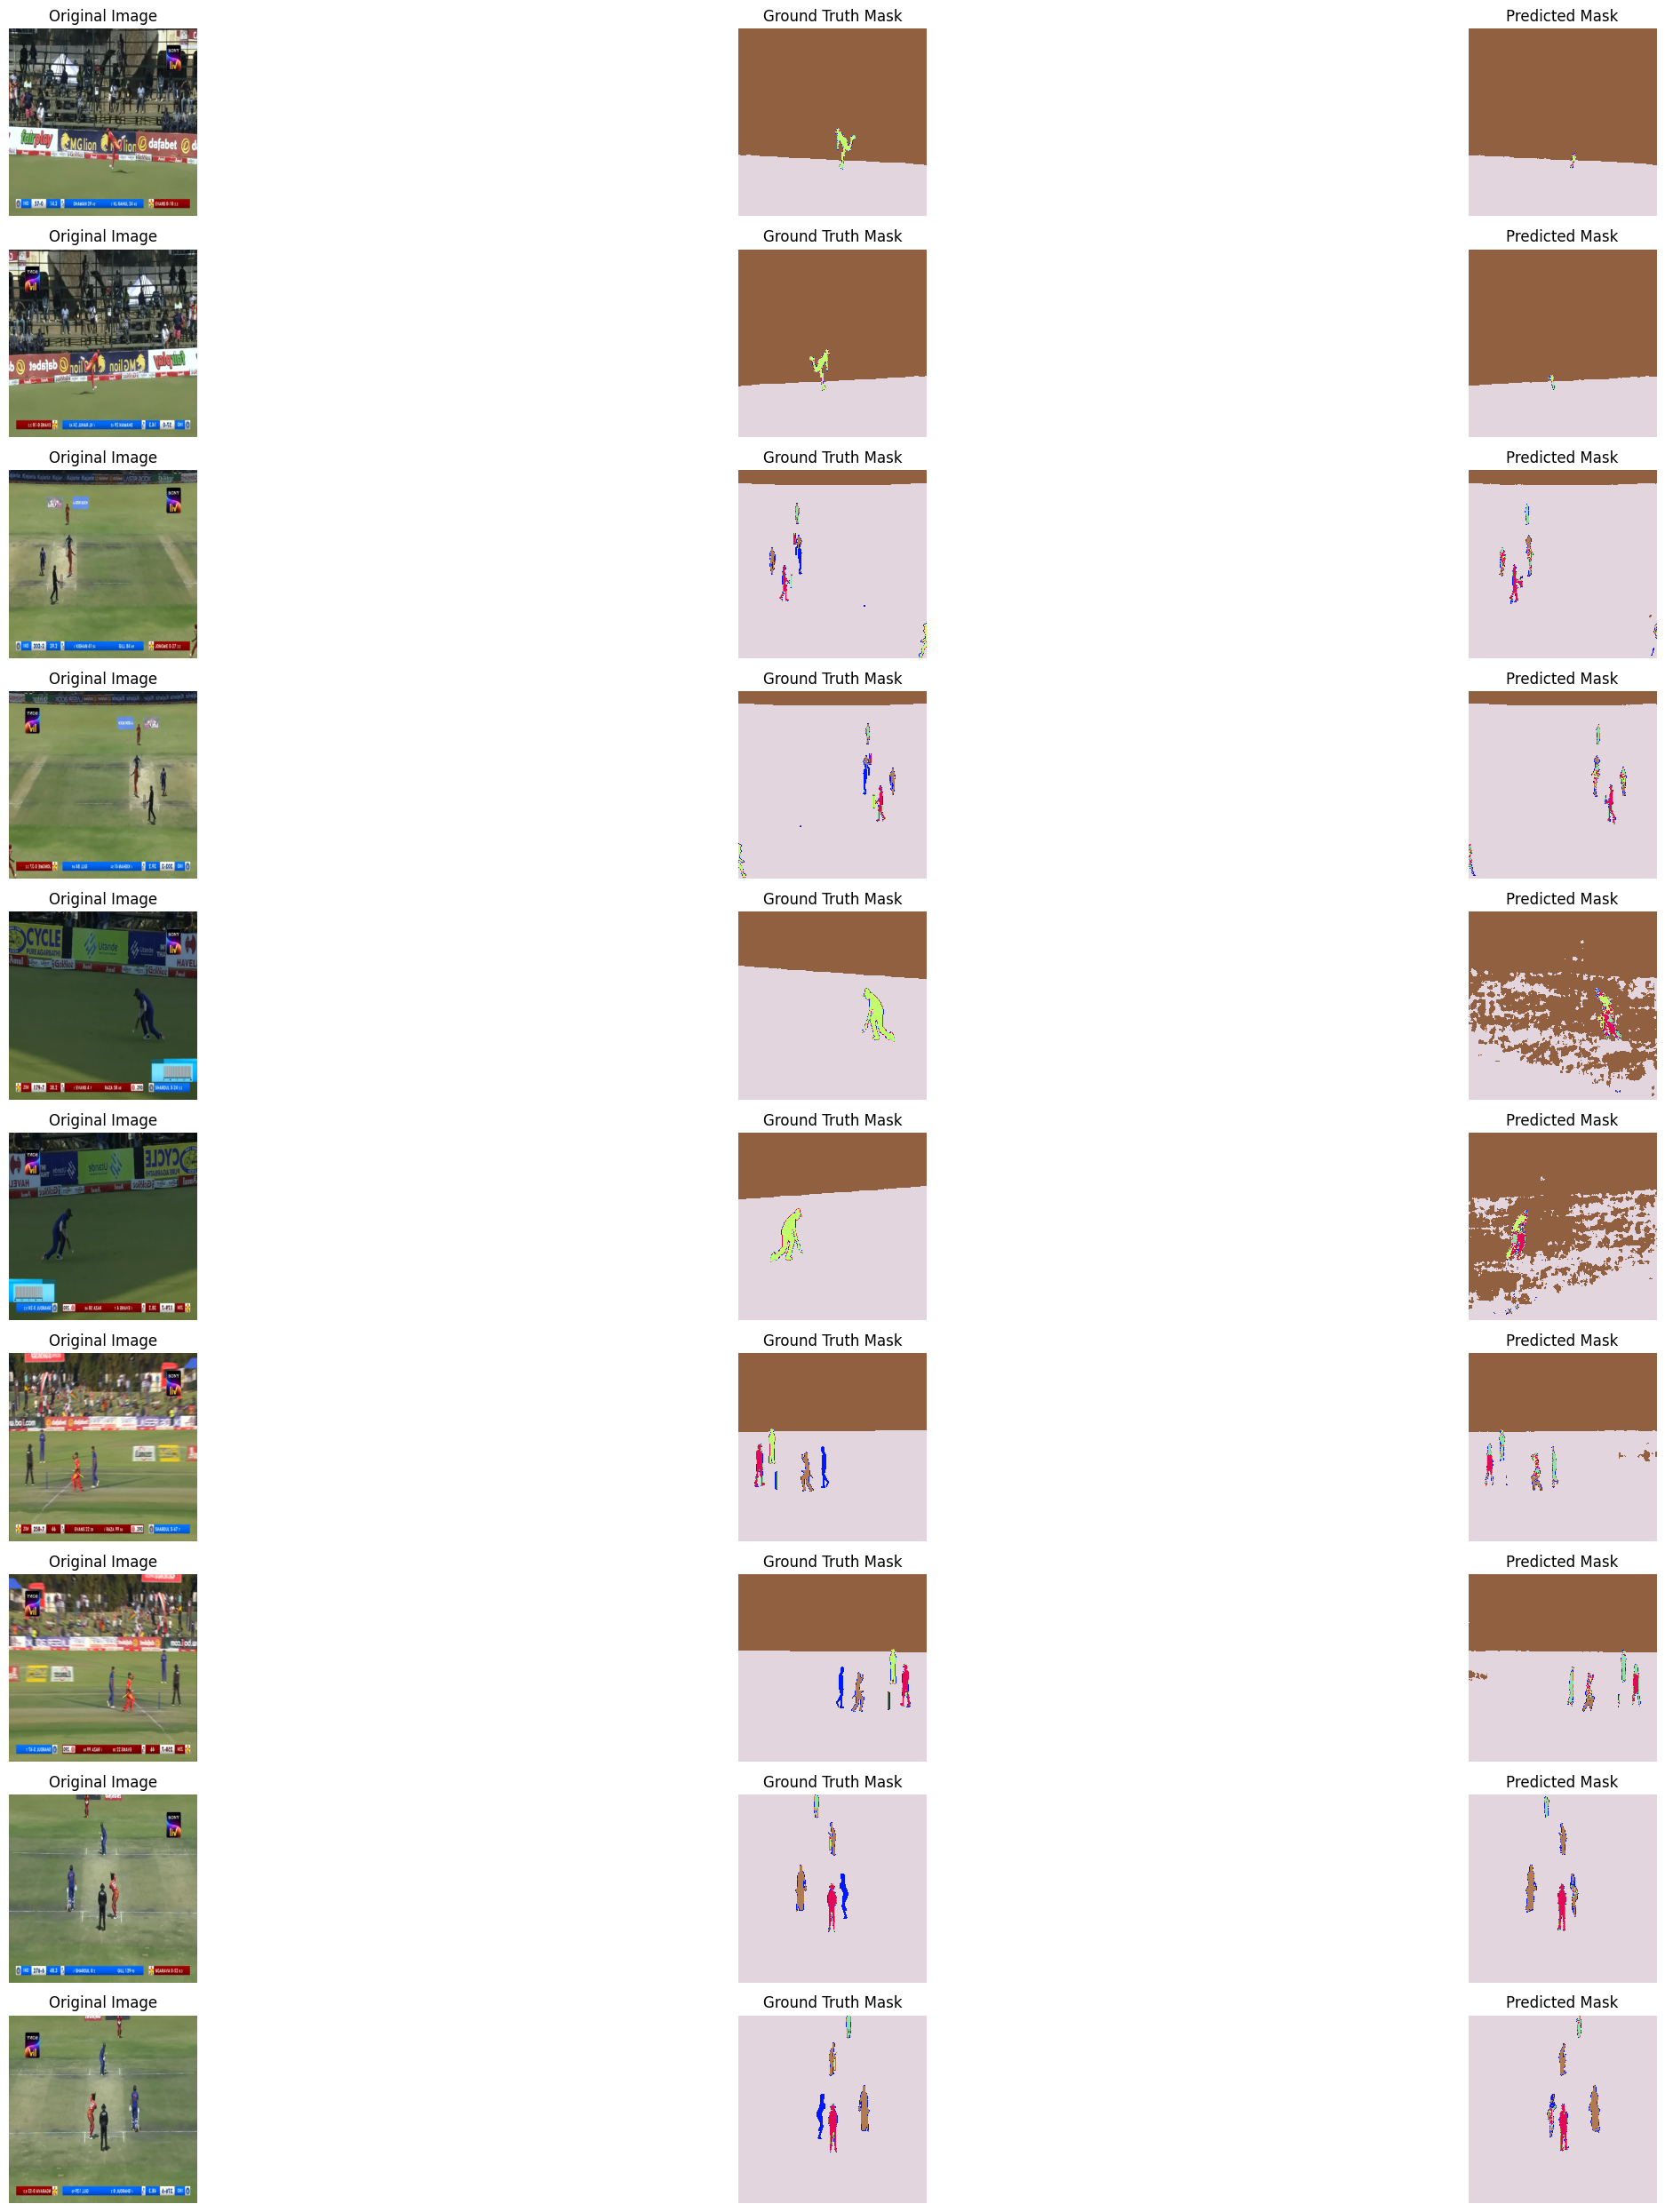

In [ ]:
model_test_3 = SegNet(9).to(device)
model_test_3.load_state_dict(torch.load("/content/drive/MyDrive/dl/segnet_final_50_epoch_1_4_lr_center_10p_lr_decay.pth"))
test_center(model_test_3,test_images_path,device,9)